# Model-based clustering for time series

## 0. Packages and imports

### Necessary packages installing and imports
**NB** : It might be necessary to restart the kernel after the installs

In [4]:
pip install pymc==5.18.2
# compatible versions for all pip uninstall pymc pytensor -y 
#pip install pymc==5.1.2 pytensor==2.10.1

SyntaxError: invalid syntax (1444087919.py, line 1)

In [ ]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, norm
import random
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import ipywidgets
from scipy.signal.windows import gaussian

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## I. The data

We chose to work with GDP data from the https://www.worldbank.org/ website on time series on the GDP in US$ millions. To do so, we chose several time series (number of countries varying between 55,60, and 71 and time horizon between 1995-2024,1998-2024, and 2000-2024). 
To have interpretable results, we normalized the values per column and total between 0 and 1. 

In the logit structure, that we will see later on, we require an exogeneous variable. For this, we chose to work with poplation size for the time horizon 1995-2024 in 55 countries. 

In [7]:
# N=55 pays, longueur T=30 ans (entre 1995 et 2024), normalisé entre 0 et 1 (par colonne et au global)
GDP_30 = pd.read_csv('../Data preprocessing/GDP_yearly_30_colnormalized', index_col=0)
GDP_global_30 = pd.read_csv('../Data preprocessing/GDP_yearly_30_global_normalized')

In [8]:
# N=71 pays, longueur T=25 ans (entre 2000 et 2024), normalisé entre 0 et 1 (par colonne et au global)
GDP_25 = pd.read_csv('../Data preprocessing/GDP_yearly_25_colnormalized', index_col=0)
GDP_global_25 = pd.read_csv('../Data preprocessing/GDP_yearly_25_global_normalized')

In [9]:
# N=60 pays, longueur T=27 ans (entre 1998 et 2024), normalisé entre 0 et 1 (par colonne et au global)
GDP_27 = pd.read_csv('../Data preprocessing/GDP_yearly_27_colnormalized', index_col=0)
GDP_global_27 = pd.read_csv('../Data preprocessing/GDP_yearly_27_global_normalized')

In [10]:
# Population totale par pays par an N=55 pays, longueur 30 ans 
pop_30 = pd.read_csv('../Data preprocessing/pop_yearly_30_colnormalized',index_col=0)
pop_global_30 = pd.read_csv('../Data preprocessing/pop_yearly_30_global_normalized')

In [11]:
GDP_30.head(5)

Argentina  Australia   Austria   Belgium  Bulgaria   Bolivia  \
Year                                                                   
1995.0   0.255100   0.000000  0.000000  0.000000  0.127484  0.000000   
1996.0   0.317617   0.030497  0.034659  0.020306  0.194087  0.025494   
1997.0   0.415351   0.068106  0.072410  0.079368  0.042826  0.055735   
1998.0   0.465062   0.107140  0.131894  0.111068  0.078101  0.088088   
1999.0   0.419842   0.145945  0.197218  0.169437  0.000000  0.090764   

          Brazil  Botswana    Canada  Switzerland  ...   Romania  \
Year                                               ...             
1995.0  0.000000  0.000000  0.000000     0.000000  ...  0.026666   
1996.0  0.022544  0.014954  0.018966     0.006323  ...  0.056416   
1997.0  0.067687  0.060813  0.067840     0.038831  ...  0.018056   
1998.0  0.072163  0.049843  0.114196     0.082504  ...  0.002778   
1999.0  0.078065  0.105176  0.177795     0.107437  ...  0.000000   

        Russian Federation  Singapore  El Salvador    Serbia  Slovenia  \
Year                                                                     
1995.0            0.061349   0.000000     0.117867  0.000000  0.000000   
1996.0            0.031720   0.028820     0.127552  0.043450  0.029625   
1997.0            0.041771   0.062948     0.163531  0.111913  0.077113   
1998.0            0.000000   0.053361     0.194751  0.159426  0.107018   
1999.0            0.045988   0.078096     0.221040  0.066885  0.159932   

          Sweden  Thailand  United States  South Africa  
Year                                                     
1995.0  0.000000  0.042127       0.000000      0.000000  
1996.0  0.020084  0.089287       0.038248      0.048832  
1997.0  0.059123  0.065465       0.085040      0.079628  
1998.0  0.109977  0.000000       0.134284      0.085704  
1999.0  0.160203  0.036479       0.189267      0.115016  

[5 rows x 52 columns]

In [12]:
pop_30.head(5)

Argentina  Australia   Austria   Belgium  Bulgaria   Bolivia  \
Year                                                                   
1995.0   0.000000   0.000000  0.000000  0.000000  1.000000  0.000000   
1996.0   0.042392   0.025408  0.009074  0.012011  0.977932  0.033656   
1997.0   0.083850   0.048319  0.016699  0.026920  0.952028  0.067107   
1998.0   0.124455   0.069644  0.024091  0.040105  0.923816  0.100405   
1999.0   0.164750   0.093295  0.037217  0.054288  0.900257  0.133913   

          Brazil  Botswana    Canada  Switzerland  ...   Romania  \
Year                                               ...             
1995.0  0.000000  0.000000  0.000000     0.000000  ...  1.000000   
1996.0  0.049943  0.037780  0.028522     0.016869  ...  0.982049   
1997.0  0.099717  0.074235  0.055916     0.026101  ...  0.964164   
1998.0  0.150278  0.110110  0.079002     0.037520  ...  0.951337   
1999.0  0.200513  0.145873  0.101800     0.055918  ...  0.941627   

        Russian Federation  Singapore  El Salvador    Serbia  Slovenia  \
Year                                                                     
1995.0            1.000000   0.000000     0.000000  1.000000  0.059374   
1996.0            0.961718   0.061090     0.078823  0.993952  0.050413   
1997.0            0.918269   0.113463     0.150590  0.970424  0.031167   
1998.0            0.874853   0.168275     0.216715  0.939787  0.000000   
1999.0            0.793907   0.181442     0.277207  0.912581  0.010199   

          Sweden  Thailand  United States  South Africa  
Year                                                     
1995.0  0.000000  0.000000       0.000000      0.000000  
1996.0  0.008223  0.065033       0.045398      0.031143  
1997.0  0.011185  0.128697       0.092938      0.060270  
1998.0  0.014058  0.191848       0.139517      0.090105  
1999.0  0.018094  0.253287       0.185935      0.117230  

[5 rows x 52 columns]

In [13]:
GDP_global_27.head()

Argentina  Australia   Austria   Belgium  Bulgaria   Bolivia    Brazil  \
0   0.015091   0.040353  0.015689  0.018966  0.001303  0.000223  0.068021   
1   0.014574   0.042161  0.016277  0.019651  0.001162  0.000226  0.068341   
2   0.014459   0.043479  0.016847  0.020396  0.001227  0.000241  0.071309   
3   0.013802   0.044620  0.017069  0.020625  0.001290  0.000252  0.072368   
4   0.012267   0.046492  0.017327  0.020984  0.001387  0.000269  0.074568   

   Botswana    Canada  Switzerland  ...  Russian Federation  Singapore  \
0  0.000000  0.059044     0.022619  ...            0.041619   0.005317   
1  0.000032  0.062099     0.022994  ...            0.044115   0.005641   
2  0.000049  0.065310     0.023956  ...            0.048590   0.006186   
3  0.000060  0.066542     0.024348  ...            0.051061   0.006117   
4  0.000093  0.068550     0.024335  ...            0.053499   0.006369   

   El Salvador    Serbia  Slovenia    Sweden  Thailand   Uruguay  \
0     0.000442  0.001117  0.001340  0.017908  0.009008  0.001309   
1     0.000460  0.000960  0.001428  0.018629  0.009443  0.001276   
2     0.000470  0.001045  0.001500  0.019546  0.009881  0.001244   
3     0.000477  0.001138  0.001556  0.019853  0.010234  0.001181   
4     0.000490  0.001238  0.001618  0.020310  0.010887  0.001060   

   United States  South Africa  
0       0.569929      0.012723  
1       0.597243      0.013038  
2       0.621610      0.013602  
3       0.627553      0.013980  
4       0.638232      0.014512  

[5 rows x 56 columns]

In [14]:
GDP_27.head()

Argentina  Australia   Austria   Belgium  Bulgaria   Bolivia  \
Year                                                                   
1998.0   0.465062   0.000000  0.000000  0.000000  0.078101  0.000000   
1999.0   0.419842   0.043460  0.075248  0.065662  0.000000  0.002935   
2000.0   0.409848   0.075163  0.148157  0.136995  0.036144  0.021531   
2001.0   0.352416   0.102593  0.176508  0.158882  0.070884  0.034685   
2002.0   0.218249   0.147604  0.209524  0.193231  0.124303  0.054367   

          Brazil  Botswana    Canada  Switzerland  ...  Russian Federation  \
Year                                               ...                       
1998.0  0.000000  0.000000  0.000000     0.000000  ...            0.000000   
1999.0  0.006361  0.058236  0.071799     0.027176  ...            0.045988   
2000.0  0.065312  0.089006  0.147254     0.096914  ...            0.128435   
2001.0  0.086347  0.108492  0.176202     0.125390  ...            0.173957   
2002.0  0.130058  0.168572  0.223374     0.124394  ...            0.218856   

        Singapore  El Salvador    Serbia  Slovenia    Sweden  Thailand  \
Year                                                                     
1998.0   0.000000     0.194751  0.099174  0.000000  0.000000  0.000000   
1999.0   0.026130     0.221040  0.000000  0.059256  0.056431  0.036479   
2000.0   0.070054     0.234952  0.053878  0.107926  0.128310  0.073154   
2001.0   0.064465     0.245866  0.112951  0.145398  0.152396  0.102717   
2002.0   0.084803     0.265309  0.176114  0.187079  0.188187  0.157387   

         Uruguay  United States  South Africa  
Year                                           
1998.0  0.193577       0.000000      0.000000  
1999.0  0.169978       0.063511      0.032060  
2000.0  0.146532       0.120167      0.089510  
2001.0  0.100792       0.133988      0.127994  
2002.0  0.012801       0.158818      0.182160  

[5 rows x 56 columns]

In [15]:
# Série différenciée + normalisée pour N=71 pays, longueur T=25 ans (entre 2000 et 2024)
GDP_25_diff_norm = pd.read_csv('../Data preprocessing/GDP_yearly_25_diff_normalized', index_col=0)

In [16]:
# Série taux de croissance pour N=71 pays, longueur T=25 ans (entre 2000 et 2024)
GDP_25_growth = pd.read_csv('../Data preprocessing/GDP_yearly_25_growth', index_col=0)

In [ ]:
# Exemple avec p(y|theta) gaussienne 


# --- Étape 1: Initialisation --- Distribution a priori
def initialize_model(y, K, e0=1.0):
    """
    Initialise les paramètres du modèle.
    y: Liste des séries temporelles [N x T]
    K: Nombre de groupes
    e0: Hyperparamètre du Dirichlet
    """
    N, T = y.shape
    eta = dirichlet.rvs([e0] * K, size=1).flatten()  # Dirichlet prior for eta
    S = np.random.choice(K, size=N)  # Random initial classification
    theta = [np.random.randn(T) for _ in range(K)]  # Paramètres pour chaque groupe
    return eta, S, theta

# --- Étape 2: Échantillonnage de S ---
def sample_S(y, theta, eta):
    """
    Échantillonne les indicateurs de groupe S.
    """
    N = len(y)
    K = len(theta)
    S = np.zeros(N, dtype=int)
    for i in range(N):
        probs = [
            norm.pdf(y[i], loc=theta[k]).prod() * eta[k]  # Probabilité conditionnelle p(yi∣θk) gaussienne
            for k in range(K)
        ]
        probs = np.array(probs)
        probs /= probs.sum()  # Normalisation
        S[i] = np.random.choice(K, p=probs)  # Échantillonnage
    return S

# --- Étape 3: Mise à jour des paramètres ---
def update_theta(y, S, K):
    """
    Met à jour les paramètres spécifiques aux groupes (theta) en fonction des données de l'affectation actuelle.
    """
    T = y.shape[1]
    theta = []
    for k in range(K):
        group_data = y[S == k]   # Contient toutes les séries appartenant au groupe k
        if len(group_data) > 0:
            theta_k = group_data.mean(axis=0)  # Posterior mean (simple estimation)
        else:
            theta_k = np.random.randn(T)  # Cas sans données : valeur aléatoire d'une distribution gaussienne standard
        theta.append(theta_k)
    return theta

def update_eta_ignorance_structure(S, K, e0=1.0):
    """
    Met à jour les probabilités a priori des paramètres eta (structure d'ignorance) influencées  par la distribution actuelle des affectations S.
    """
    counts = np.bincount(S, minlength=K) + e0  # Comptes augmentés par le prior (nombre d'observations assignées à chaque groupe k + e0)
    return dirichlet.rvs(counts, size=1).flatten()

# --- Étape 4: MCMC ---
def mcmc(y, K, num_iter=1000, e0=1.0):
    """
    Effectue l'estimation via MCMC.
    """
    eta, S, theta = initialize_model(y, K, e0)
    for iteration in range(num_iter):
        # Échantillonnage de S
        S = sample_S(y, theta, eta)
        # Mise à jour de theta
        theta = update_theta(y, S, K)
        # Mise à jour de eta
        eta = update_eta_ignorance_structure(S, K, e0)
    return S, theta, eta

# Exécution pour des données synthétiques

# Génération de données synthétiques
np.random.seed(42)
N, T, K = 100, 50, 3
true_theta = [np.random.randn(T) for _ in range(K)]
y = np.vstack([np.random.randn(1, T) + true_theta[k] for k in np.random.choice(K, N)])

# Estimation MCMC
S_est, theta_est, eta_est = mcmc(y, K, num_iter=500)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)

# Exécution pour des données réelles normalisées

np.random.seed(42)

# Conversion en tableau NumPy
y = GDP_global_25.values.T  # Transpose pour avoir (N, T)
print(y.shape)  

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC

# Estimation MCMC
S_est, theta_est, eta_est = mcmc(y, K, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)

# Exécution pour des données réelles normalisées sur l'ensemble

np.random.seed(42)

# Conversion en tableau NumPy
y_global = GDP_global_30.values.T  # Transpose pour avoir (N, T)
print(y.shape)  

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC

# Estimation MCMC
S_est, theta_est, eta_est = mcmc(y_global, K, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)

# II. The model 

We cant to formulate a time series model for each univariate time series $\mathbb{Y}_i = \{y_{i,1},...,y_{i,T}\}$. 
The model relies on a sampling density for $\mathbb{Y}_i$ which is : 

$p(\mathbb{Y}_i | \theta) = \prod_{t=t_0}^T p(y_{i,t} | \mathbb{Y}_i^{t-1}, \theta ), \text{where } \theta \in \Theta, \mathbb{Y}_i^{t-1} = \{y_{i,1},...,y_{i,t-1} \} $. 

We tried to model the density of $y_{i,t} | \mathbb{Y}_i^{t-1}, \theta$ by several distributions. The first try was with a Gaussian distribution but the results were not concluding. In order to account for the complexity of the model we chose to model it by an $AR(p)$, which gives us the following : 

$y_{i,t} | \mathbb{Y}_i^{t-1}, \theta \sim \mathcal{N}(c + \delta_1 y_{i,t-1} + ... + \delta_p y_{i,t-p}, \sigma^2)$. 

Once the model for $y_{i,t} | \mathbb{Y}_i^{t-1}, \theta$ is chosen, there remains to compute the clustering. The $N$ time series under study are supposed to arise from $K$ groups and we define the latent indicator $S_i = k$ if $\mathbb{Y}_i$ belongs to group $k$ :

$p( \mathbb{Y}_i | S_i, \theta_1, ..., \theta_K) = p( \mathbb{Y}_i | \theta_{S_i}) = \begin{cases}
    p( \mathbb{Y}_i | \theta_1) &\text{ if } S_i = 1 \\
    \vdots \\
    p( \mathbb{Y}_i | \theta_K) &\text{ if } S_i = K
\end{cases}$


The same model is valid in all clusters, but with different parameters $\theta_k$. Also, in this specification the $\mathbb{Y}_i$'s are independent within each cluster. 

We can derive the following joint distribution: 
$p(\mathbb{Y}_1, ..., \mathbb{Y}_N | S_1, ..., S_N, \theta_1, ..., \theta_K) = \prod_{k=1}^K \prod_{i: S_i=k} p(\mathbb{Y}_i | \theta_k)$. 

Our computational work here, beyond computing the clustering method, is to rely on 2 modellings for the probabilistic structure of the groups. Recall the group indicators $\mathbb{S}=(S_1, ..., S_N)$. We assume $S_i$'s are a priori independent and implement here 2 models : 

- Ignorance structure : complete ignorance about the group membership of a certain unit. Hence, $S_i$ has a uniform prior, given by : $\Pr(S_i=k | \eta_1,..., \eta_{K-1}) = \eta_k$, 
where $\eta_k$ is the relative size of group $k$ and $\eta_K = 1- \sum_{k=1}^{K-1} \eta_k$. $(\eta_1,...,\eta_K)$ are unknown model parameters estimated along with the data.

- Logit-type structure : a unit-specific factor might contain information on how to group the time series. This factor could be economic, geographic, or sociopolitical. We can then define a logit-type model for $\Pr(S_i=k)$. For instance, for $K=2$ and a unit-specific exogenous variable $z_i$, we have the following prior for $S_i$: 

$\Pr(S_i=2 | \gamma_1, \gamma_2, z_i) = \frac{\exp (\gamma_1 + z_i \gamma_2)}{1 + \exp(\gamma_1 + z_i \gamma_2)}$ where $(\gamma_1, \gamma_2)$ are unknown parameters to be estimated from the data.



##  II. 1. Determining the adapted ARMA(p, q) model 

1) Mise à jour des paramètres selon la posterior avec ARMA + calculer p(y_i | theta_k) pour un modèle ARMA

2) Chercher prior logit avec K > 2

3) Vérifier la posterior Dirichlet

4) Revoir estimation du nb de clusters optimal et bridge sampling

To choose the model we will use to model the data, we tried several structure, on the whole panel data (overall pooling). We focus on models like $AR(1)$ and $AR(2)$ with and without constants. 

### First test : AR(1) without constant

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


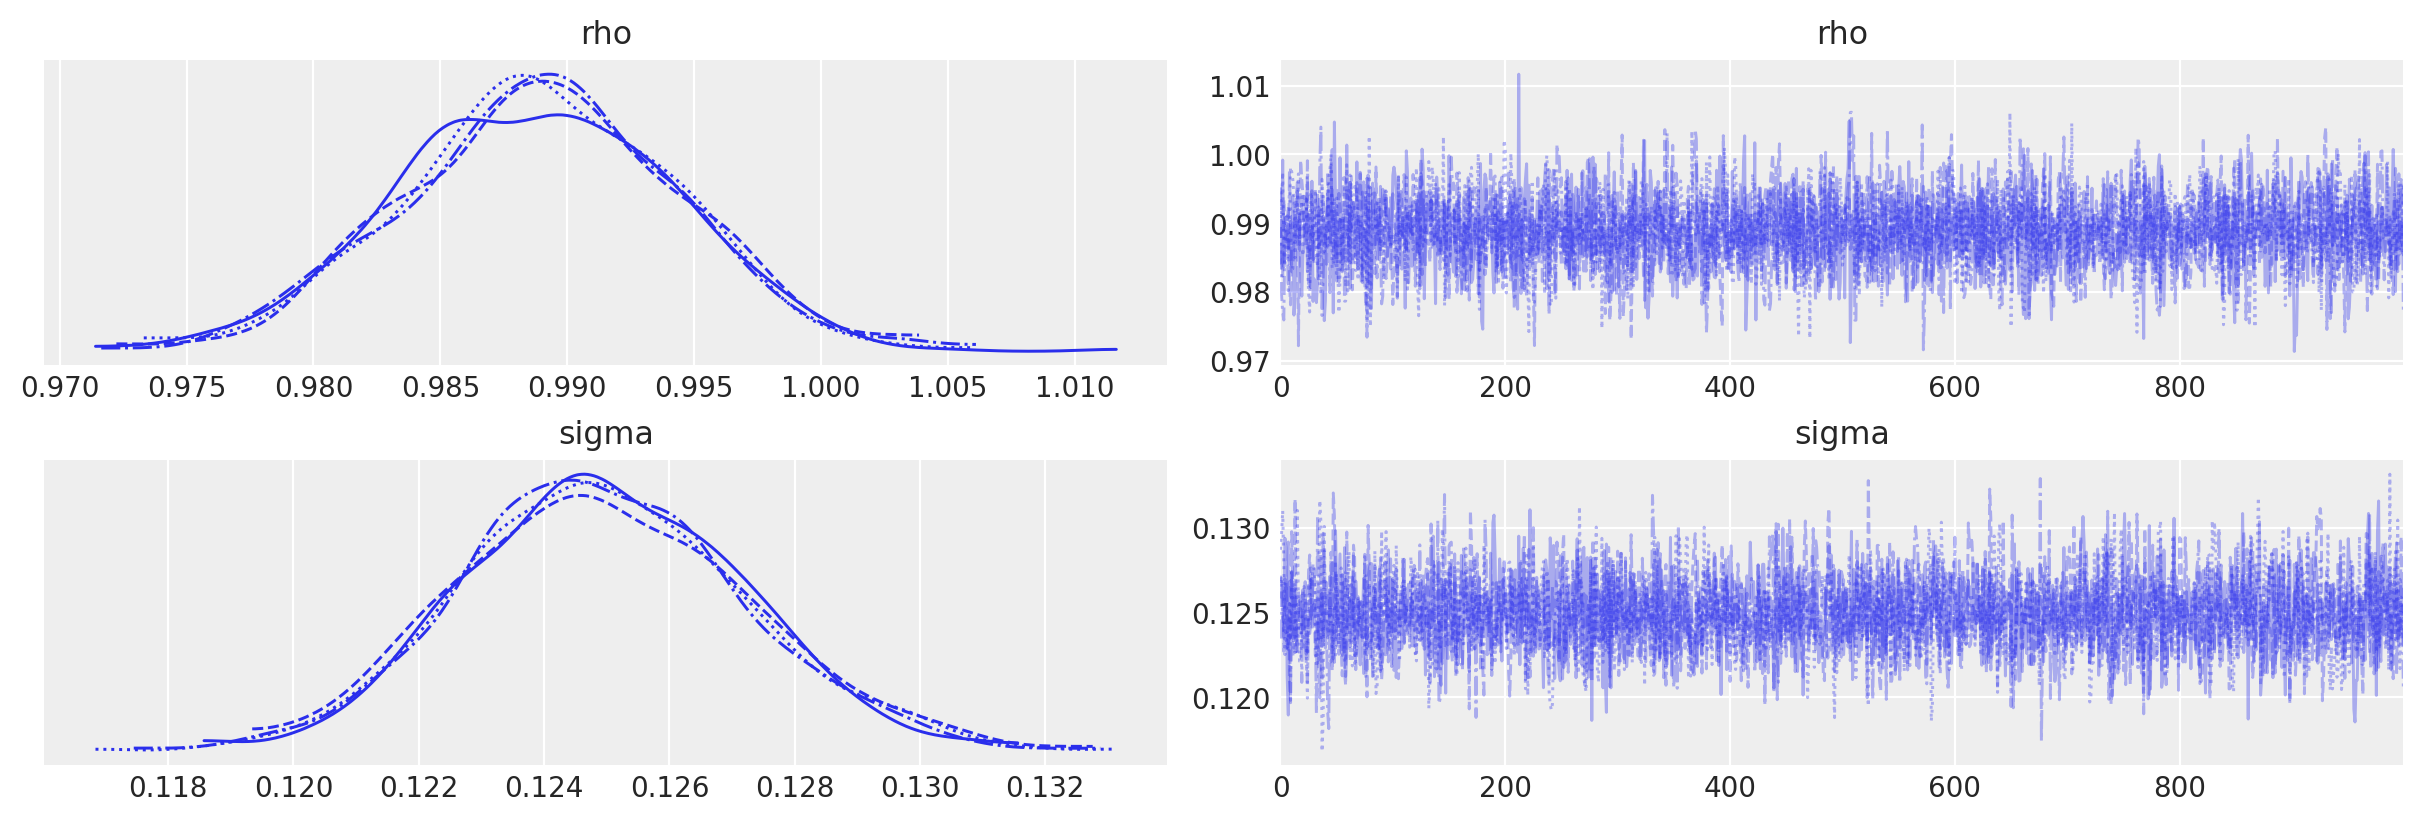

In [17]:
# AR(1) no constant
y = GDP_30.T # NB : il faut que les pays soient en lignes (df NxT)

with pm.Model() as ar1nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1nc.extend(pm.compute_log_likelihood(idata_ar1nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1nc
);

In [ ]:
idata_ar1nc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [18]:
# Statistics
az.summary(idata_ar1nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.989  0.005   0.979    0.999        0.0      0.0    4056.0    2810.0   
sigma   0.125  0.002   0.121    0.129        0.0      0.0    3884.0    2732.0   

        r_hat  
rho[0]    1.0  
sigma     1.0

In [19]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1nc.log_likelihood.ar1nc.sum(["ar1nc_dim_0"]).mean(["chain","draw"]).values

array(830.07223137)

### Second test : AR(1) with constant

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


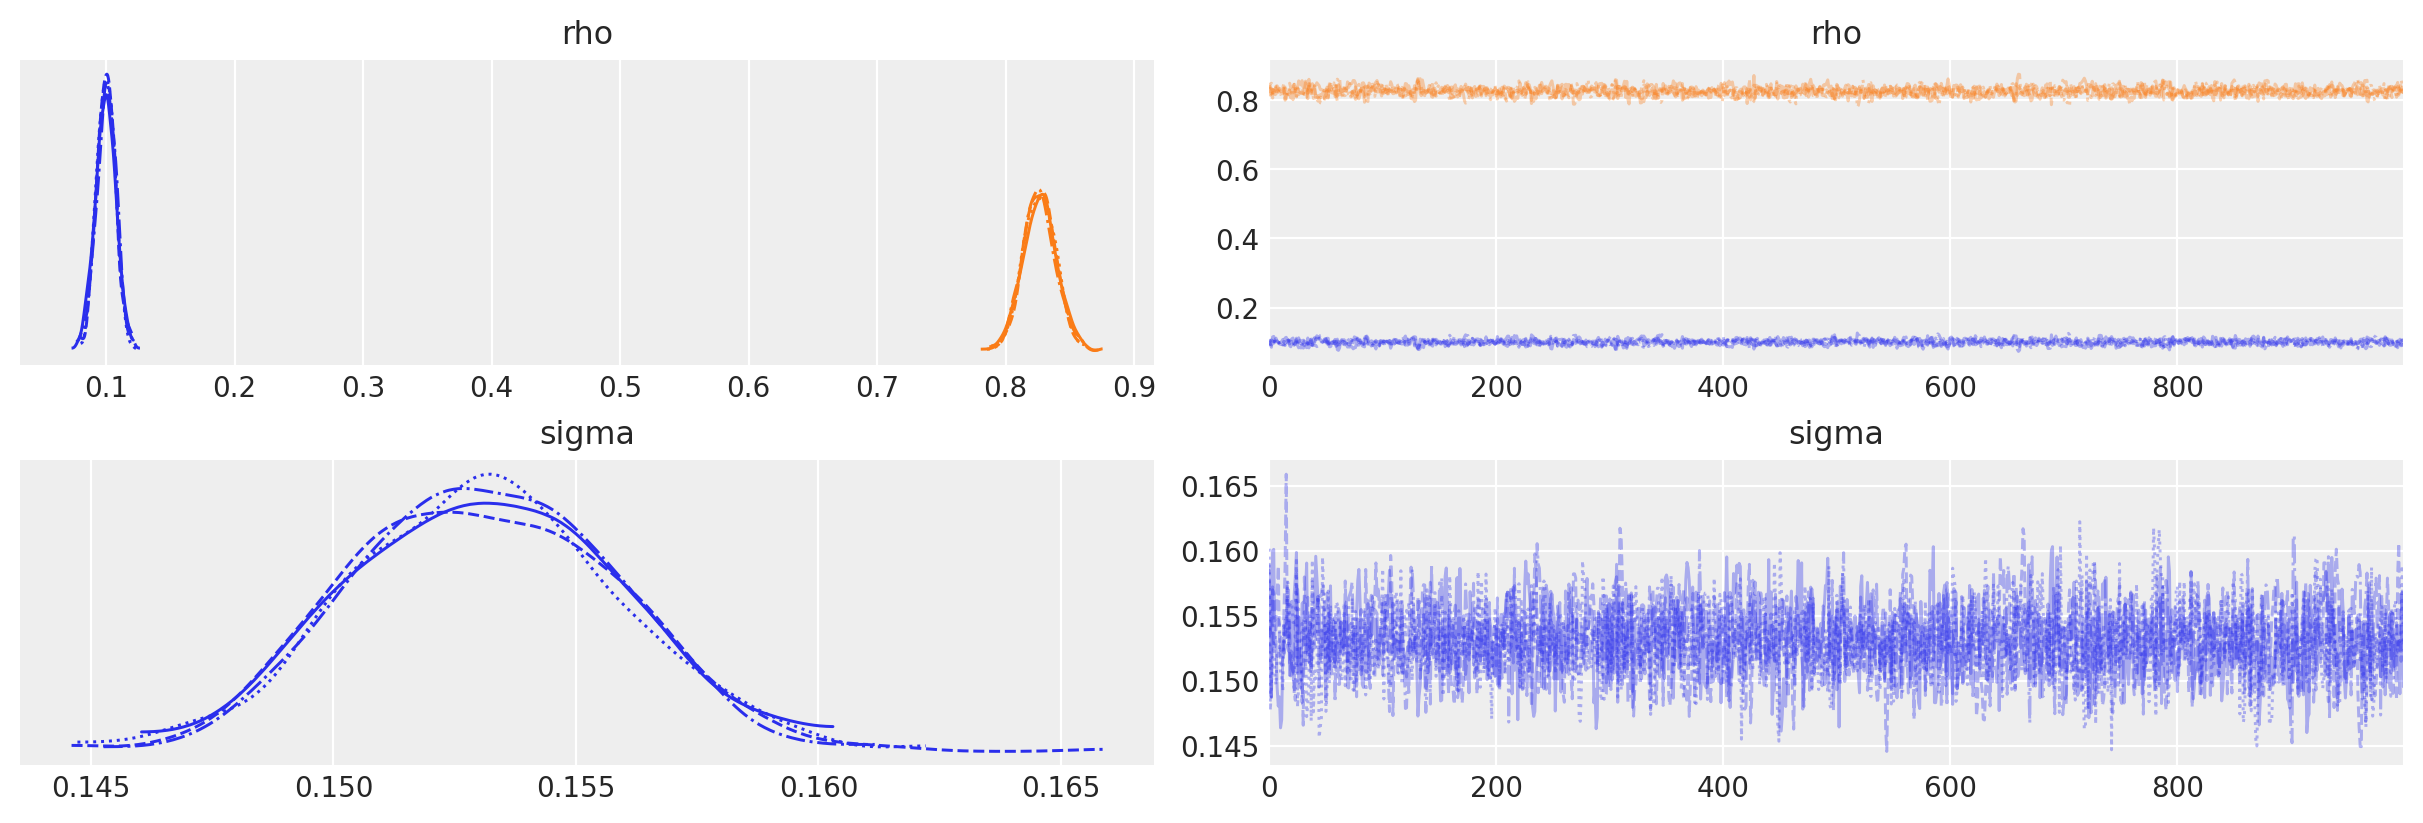

In [20]:
# AR(1) with constant
y = GDP_25.T

with pm.Model() as ar1wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1wc.extend(pm.compute_log_likelihood(idata_ar1wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1wc
);

In [21]:
# Stats des coefs
az.summary(idata_ar1wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.100  0.008   0.086    0.114        0.0      0.0    1508.0    1533.0   
rho[1]  0.826  0.013   0.804    0.851        0.0      0.0    1480.0    1509.0   
sigma   0.153  0.003   0.148    0.158        0.0      0.0    2304.0    1826.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [22]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1wc.log_likelihood.ar1wc.sum(["ar1wc_dim_0"]).mean(["chain","draw"]).values

array(521.87673313)

### AR(2) without constant

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

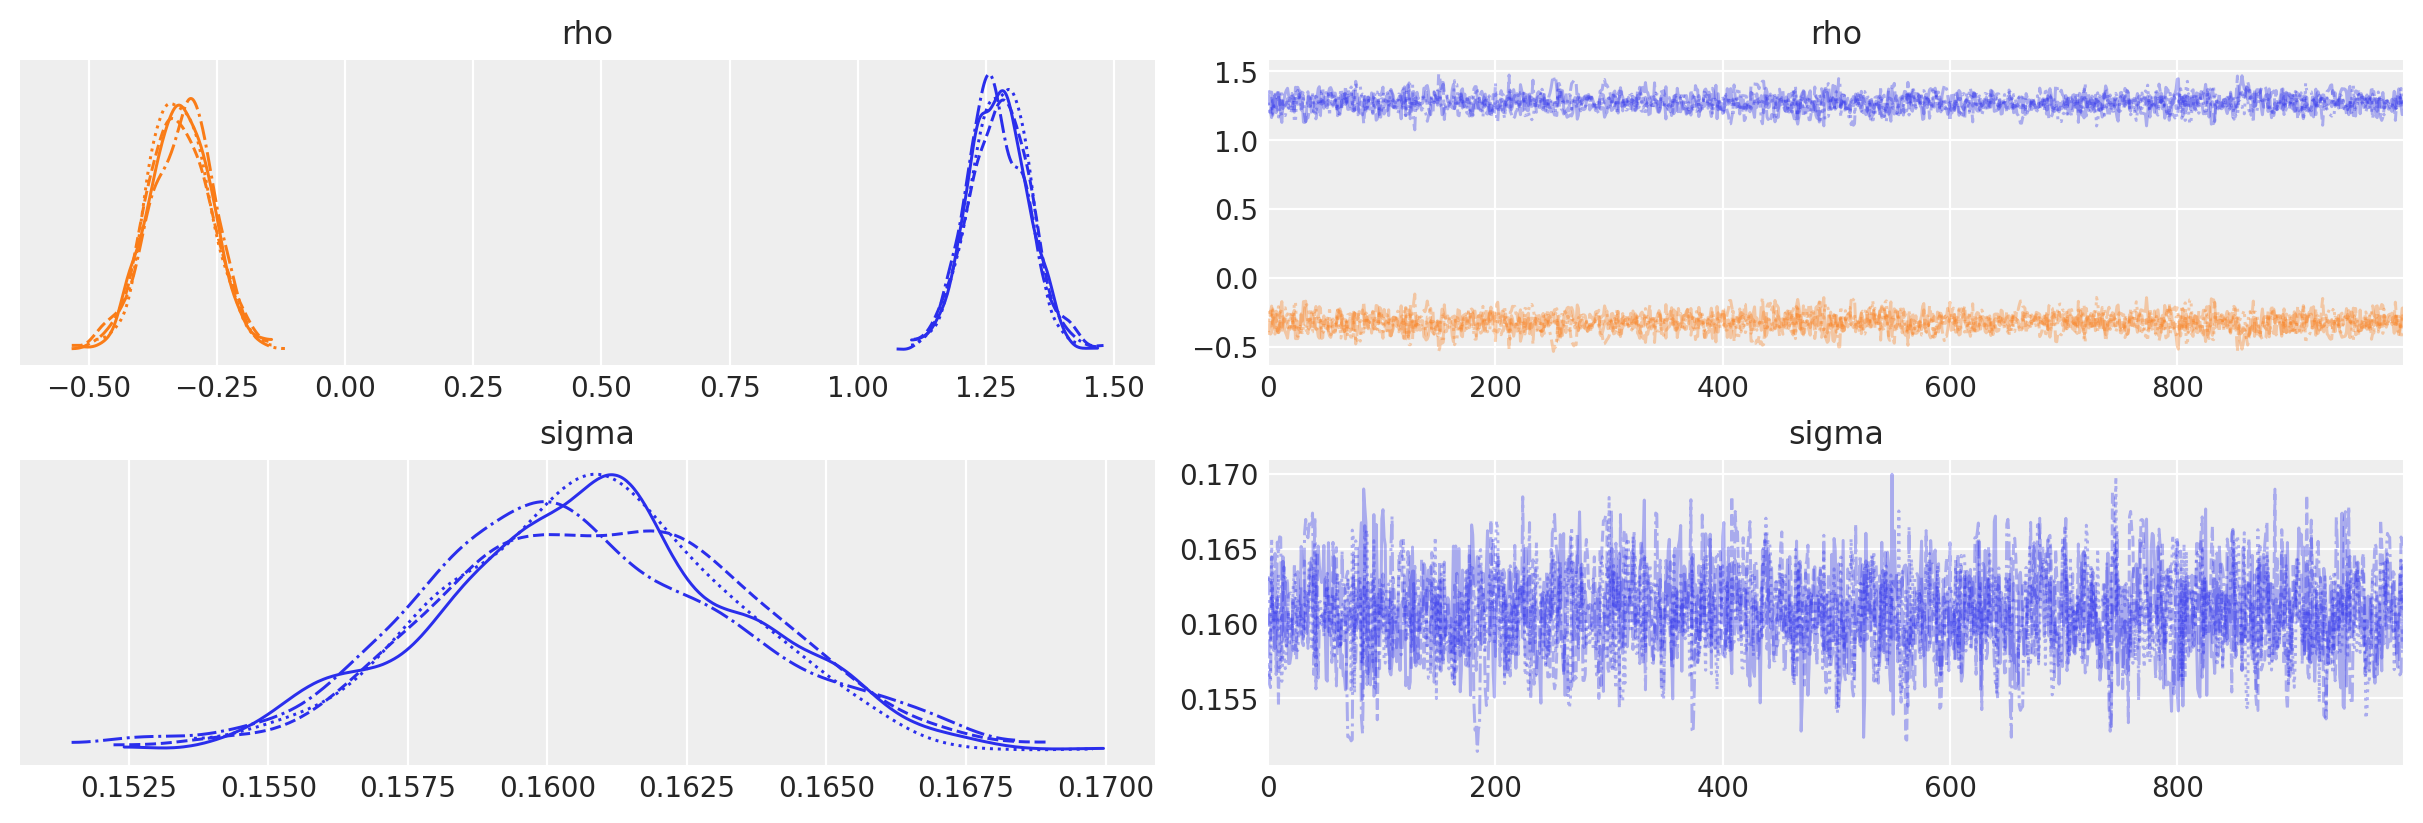

In [ ]:
# AR(2) no constant
y = GDP_25.T

with pm.Model() as ar2nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )
    
    idata_ar2nc.extend(pm.compute_log_likelihood(idata_ar2nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2nc
);

In [ ]:
# Stats des coefs
az.summary(idata_ar2nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  1.274  0.058   1.163    1.379      0.002    0.001    1243.0    1368.0   
rho[1] -0.322  0.061  -0.427   -0.196      0.002    0.001    1255.0    1436.0   
sigma   0.161  0.003   0.156    0.166      0.000    0.000    1686.0    1807.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [ ]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2nc.log_likelihood.ar2nc.sum(["ar2nc_dim_0"]).mean(["chain","draw"]).values

array(211.76836581)

### AR(2) with constant

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

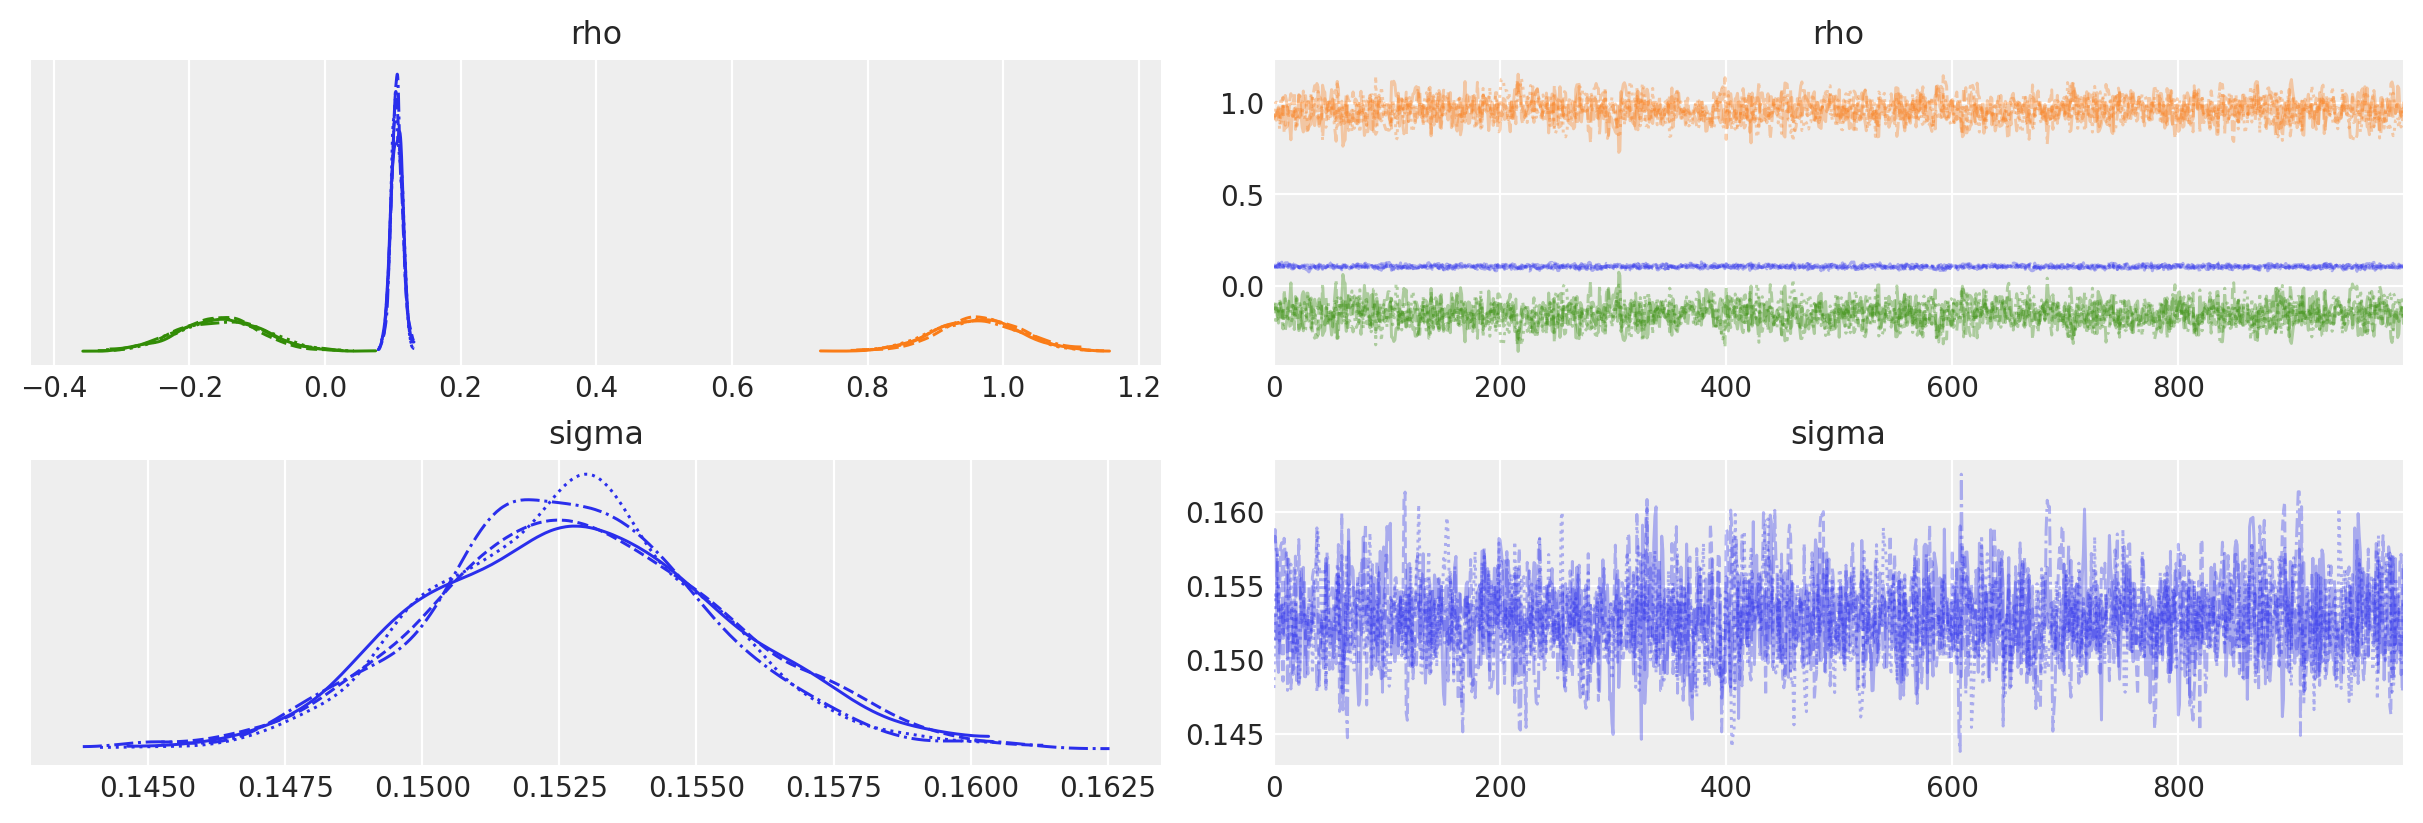

In [ ]:
# AR(2) with constant
y = GDP_25.T

with pm.Model() as ar2wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=3)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar2wc.extend(pm.compute_log_likelihood(idata_ar2wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2wc
);

In [ ]:
# Stats des coefs
az.summary(idata_ar2wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.106  0.008   0.090    0.121      0.000    0.000    2195.0    2124.0   
rho[1]  0.963  0.062   0.841    1.075      0.002    0.001    1340.0    1756.0   
rho[2] -0.153  0.062  -0.269   -0.038      0.002    0.001    1407.0    1695.0   
sigma   0.153  0.003   0.148    0.158      0.000    0.000    2420.0    2067.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
rho[2]    1.0  
sigma     1.0

In [ ]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2wc.log_likelihood.ar2wc.sum(["ar2wc_dim_0"]).mean(["chain","draw"]).values

array(293.89577252)

Based on the previous results, we get the following ovservations : 
- The coefficients for the $AR(2)$ with constant and $AR(2)$ without constant are very variant so the model is not satisfying 
- Both the $AR(1)$ with and without constant are reliable models, with coefficients that do not vary much. The log-likelihood is higher for the $AR(1)$ with constant. 

Hence, we choose the model $AR(1)$ with constant. 

### Série différenciée + normalisée

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

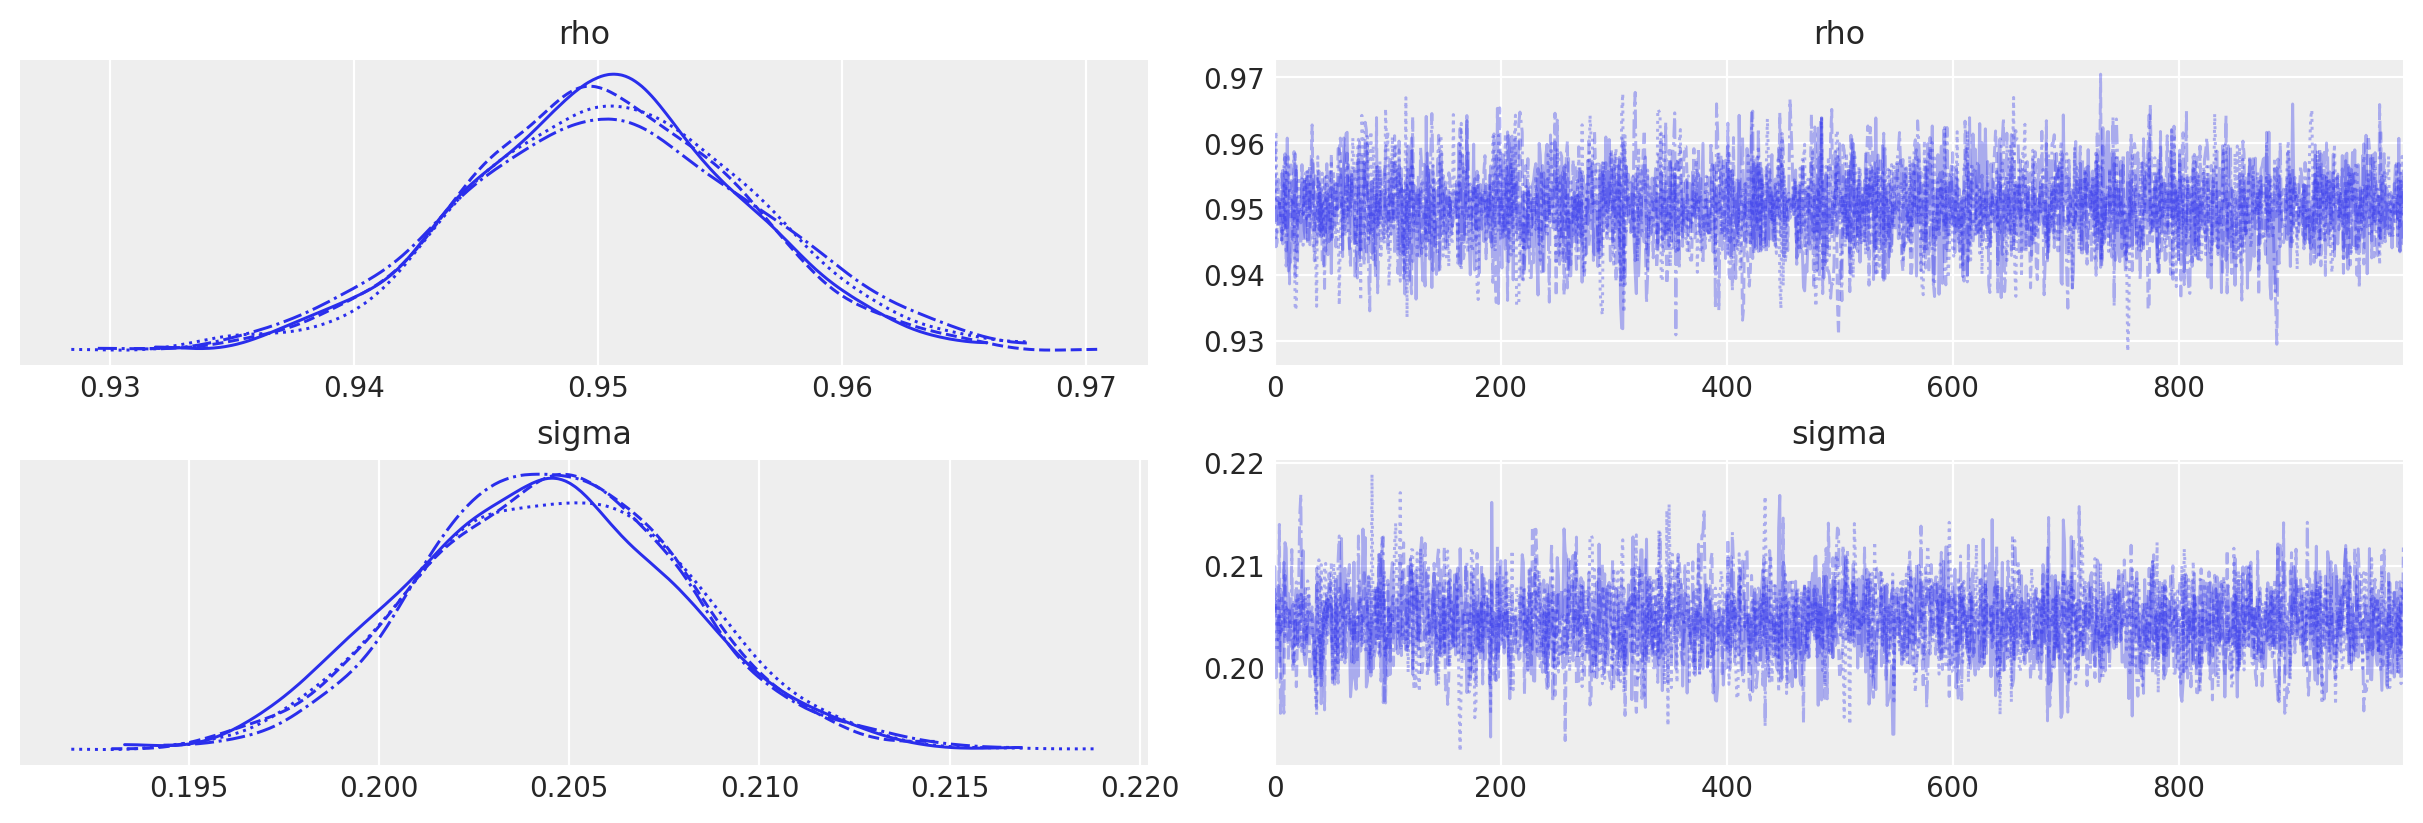

In [ ]:
# AR(1) no constant
y = GDP_25_diff_norm.T # NB : il faut que les pays soient en lignes (df NxT)

with pm.Model() as ar1nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1nc.extend(pm.compute_log_likelihood(idata_ar1nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1nc
);

In [ ]:
# Stats des coefs
az.summary(idata_ar1nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.950  0.006   0.940    0.962        0.0      0.0    4076.0    2793.0   
sigma   0.204  0.004   0.198    0.211        0.0      0.0    3148.0    2307.0   

        r_hat  
rho[0]    1.0  
sigma     1.0

In [ ]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1nc.log_likelihood.ar1nc.sum(["ar1nc_dim_0"]).mean(["chain","draw"]).values

array(45.66201752)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.


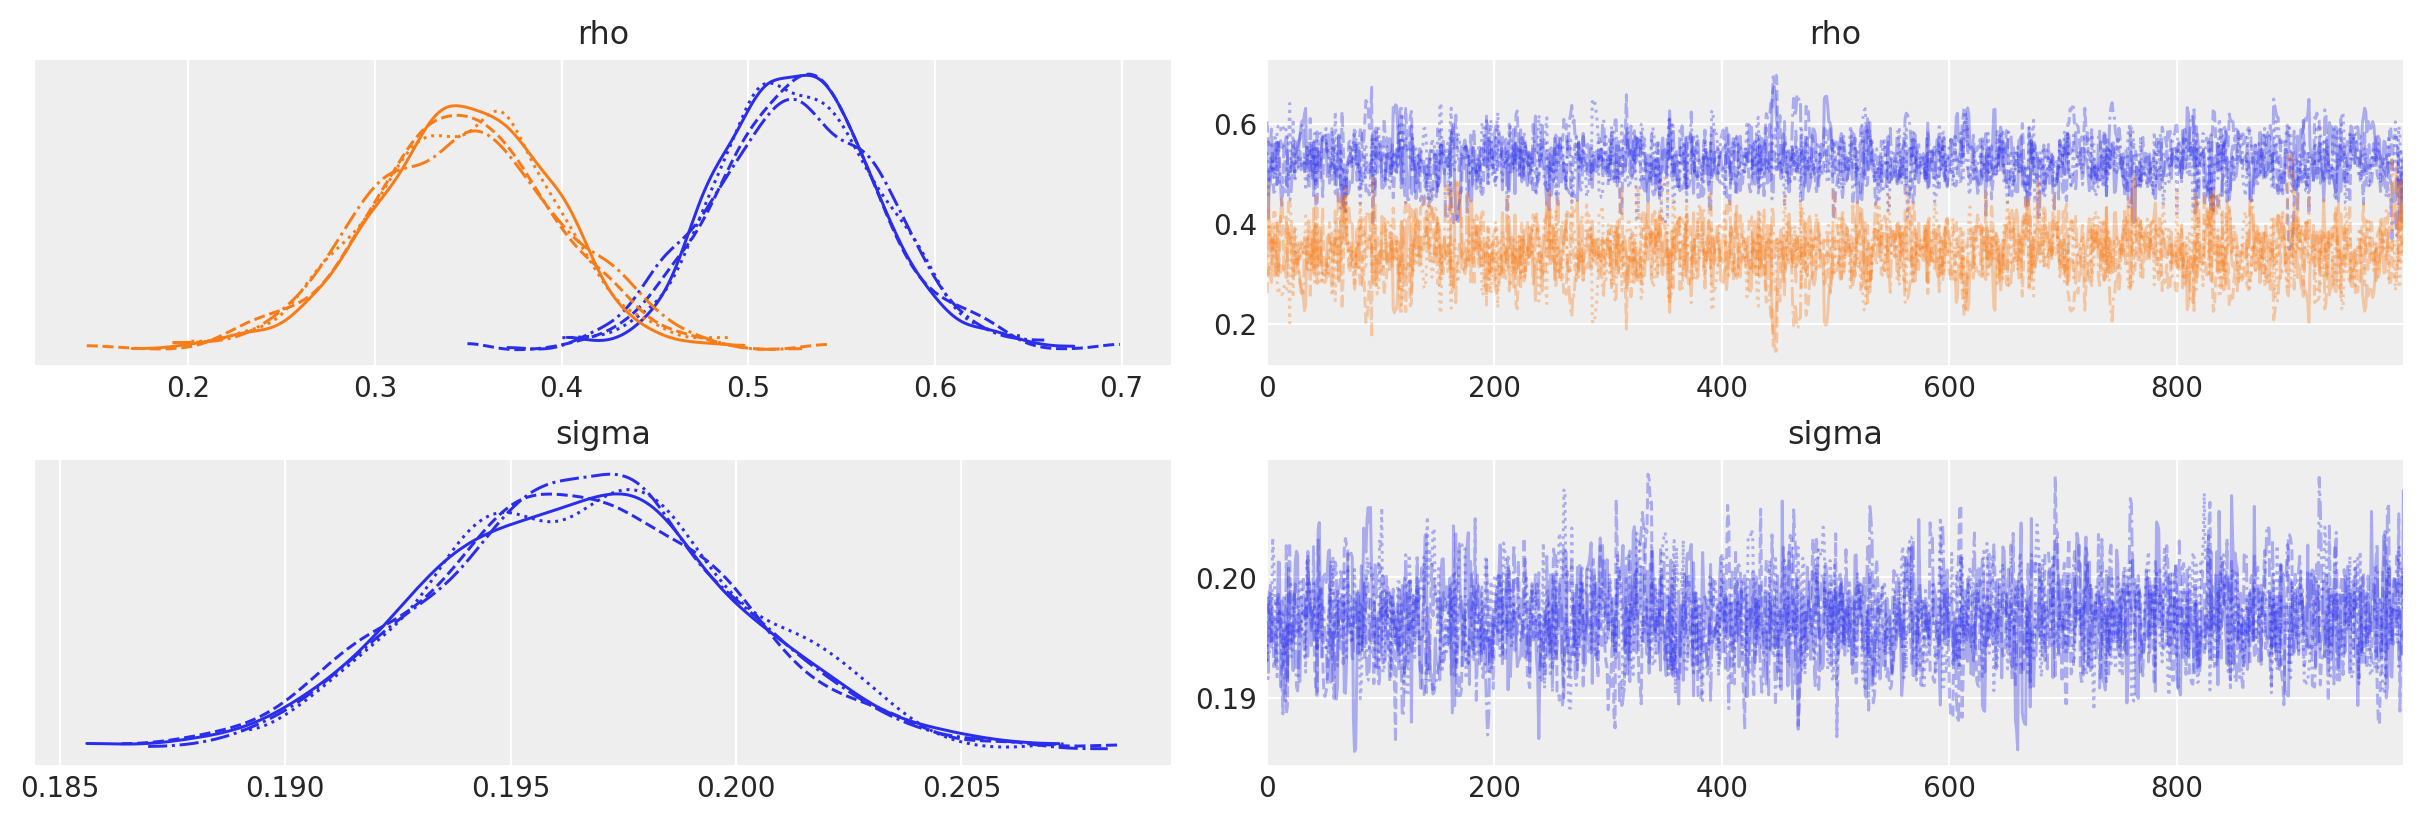

In [23]:
# AR(1) with constant
y = GDP_25_diff_norm.T

with pm.Model() as ar1wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1wc.extend(pm.compute_log_likelihood(idata_ar1wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1wc
);

In [24]:
# Stats des coefs
az.summary(idata_ar1wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.526  0.044   0.442    0.609      0.001    0.001     980.0    1180.0   
rho[1]  0.347  0.051   0.251    0.444      0.002    0.001     988.0    1250.0   
sigma   0.197  0.003   0.190    0.203      0.000    0.000    1951.0    1881.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [25]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1wc.log_likelihood.ar1wc.sum(["ar1wc_dim_0"]).mean(["chain","draw"]).values

array(111.25665497)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


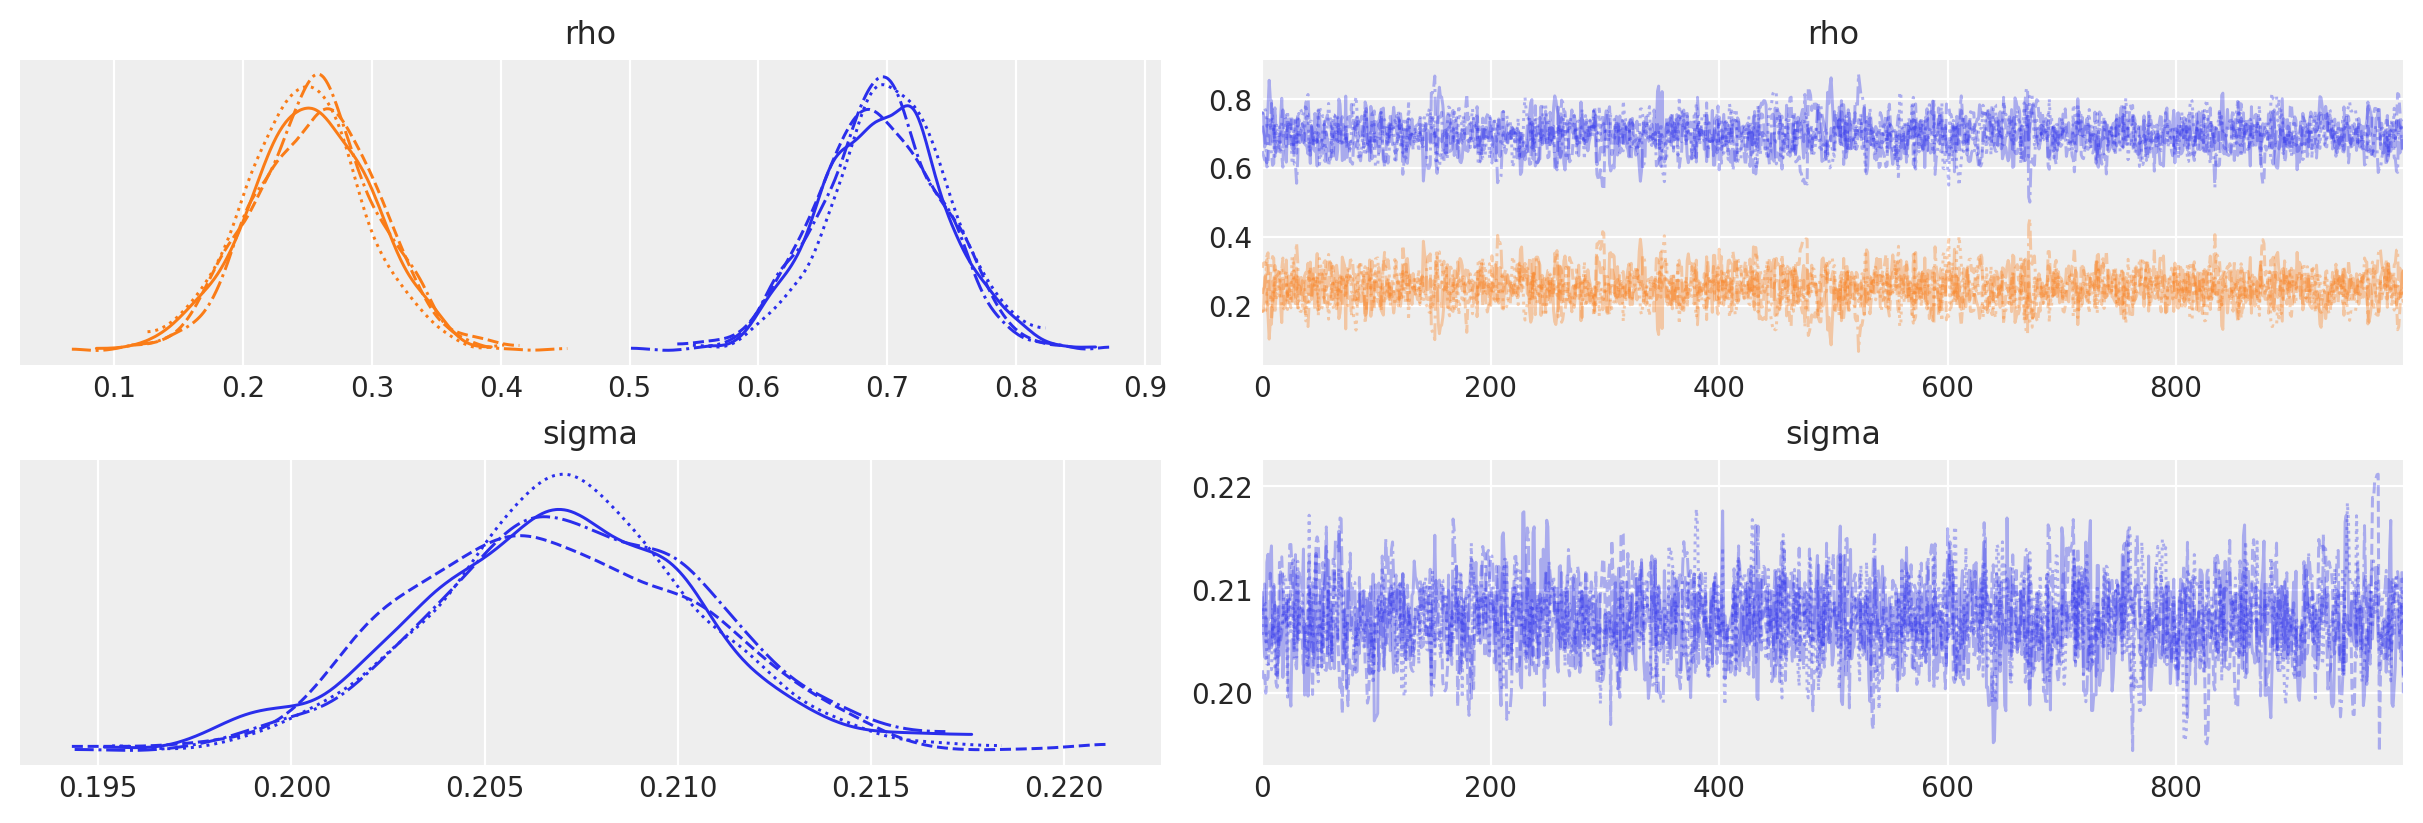

In [26]:
# AR(2) no constant
y = GDP_25_diff_norm.T

with pm.Model() as ar2nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )
    
    idata_ar2nc.extend(pm.compute_log_likelihood(idata_ar2nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2nc
);

In [27]:
# Stats des coefs
az.summary(idata_ar2nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.697  0.048   0.608    0.787      0.001    0.001    1355.0    1499.0   
rho[1]  0.253  0.048   0.164    0.343      0.001    0.001    1343.0    1504.0   
sigma   0.207  0.004   0.200    0.214      0.000    0.000    1607.0    1657.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [28]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2nc.log_likelihood.ar2nc.sum(["ar2nc_dim_0"]).mean(["chain","draw"]).values

array(-214.17742712)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.


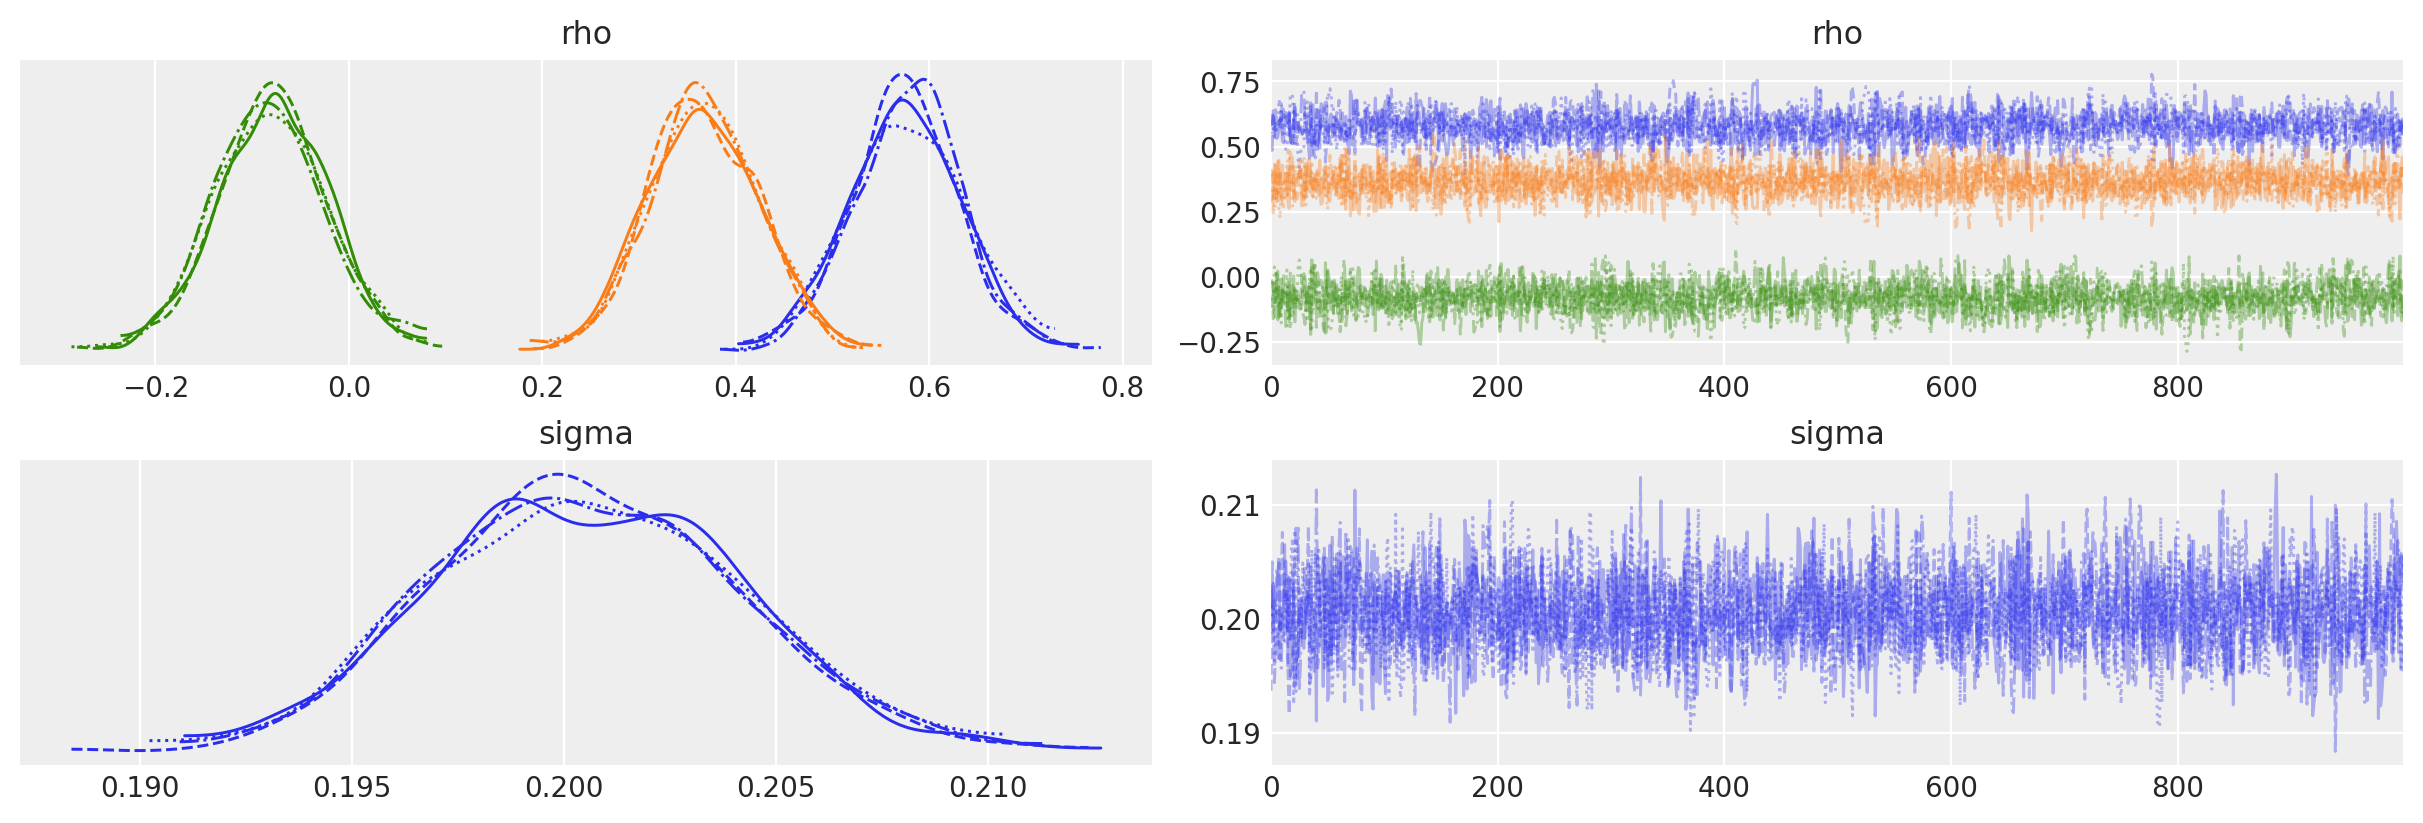

In [29]:
# AR(2) with constant
y = GDP_25_diff_norm.T

with pm.Model() as ar2wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=3)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar2wc.extend(pm.compute_log_likelihood(idata_ar2wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2wc
);

In [30]:
# Stats des coefs
az.summary(idata_ar2wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.577  0.057   0.466    0.683      0.001    0.001    1971.0    1756.0   
rho[1]  0.367  0.057   0.262    0.472      0.001    0.001    2609.0    2312.0   
rho[2] -0.080  0.058  -0.184    0.035      0.001    0.001    2378.0    2040.0   
sigma   0.201  0.004   0.194    0.207      0.000    0.000    3081.0    2316.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
rho[2]    1.0  
sigma     1.0

In [31]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2wc.log_likelihood.ar2wc.sum(["ar2wc_dim_0"]).mean(["chain","draw"]).values

array(-164.19747356)

### Série growth

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

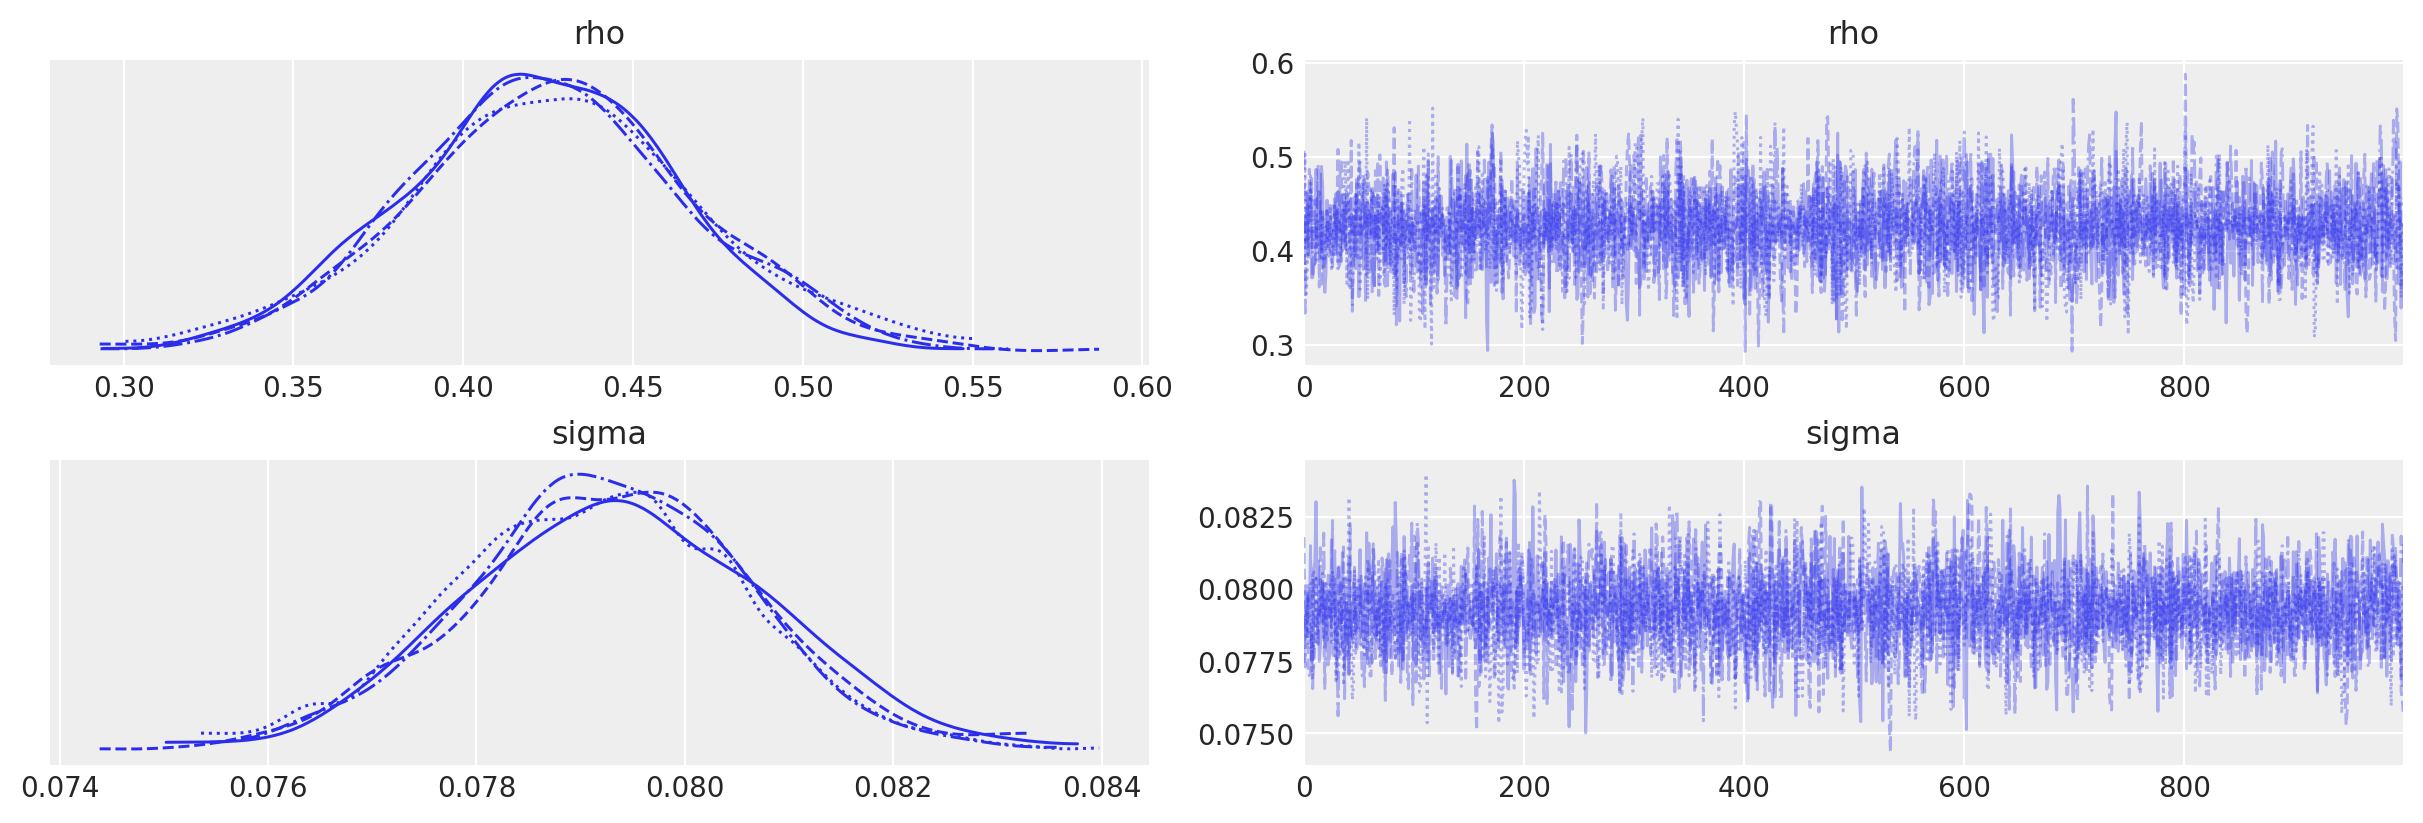

In [ ]:
# AR(1) no constant
y = GDP_25_growth.T # NB : il faut que les pays soient en lignes (df NxT)

with pm.Model() as ar1nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1nc.extend(pm.compute_log_likelihood(idata_ar1nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1nc
);

In [ ]:
# Stats des coefs
az.summary(idata_ar1nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.425  0.042   0.346    0.503      0.001      0.0    3986.0    2776.0   
sigma   0.079  0.001   0.077    0.082      0.000      0.0    3665.0    2997.0   

        r_hat  
rho[0]    1.0  
sigma     1.0

In [ ]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1nc.log_likelihood.ar1nc.sum(["ar1nc_dim_0"]).mean(["chain","draw"]).values

array(1594.10182791)

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

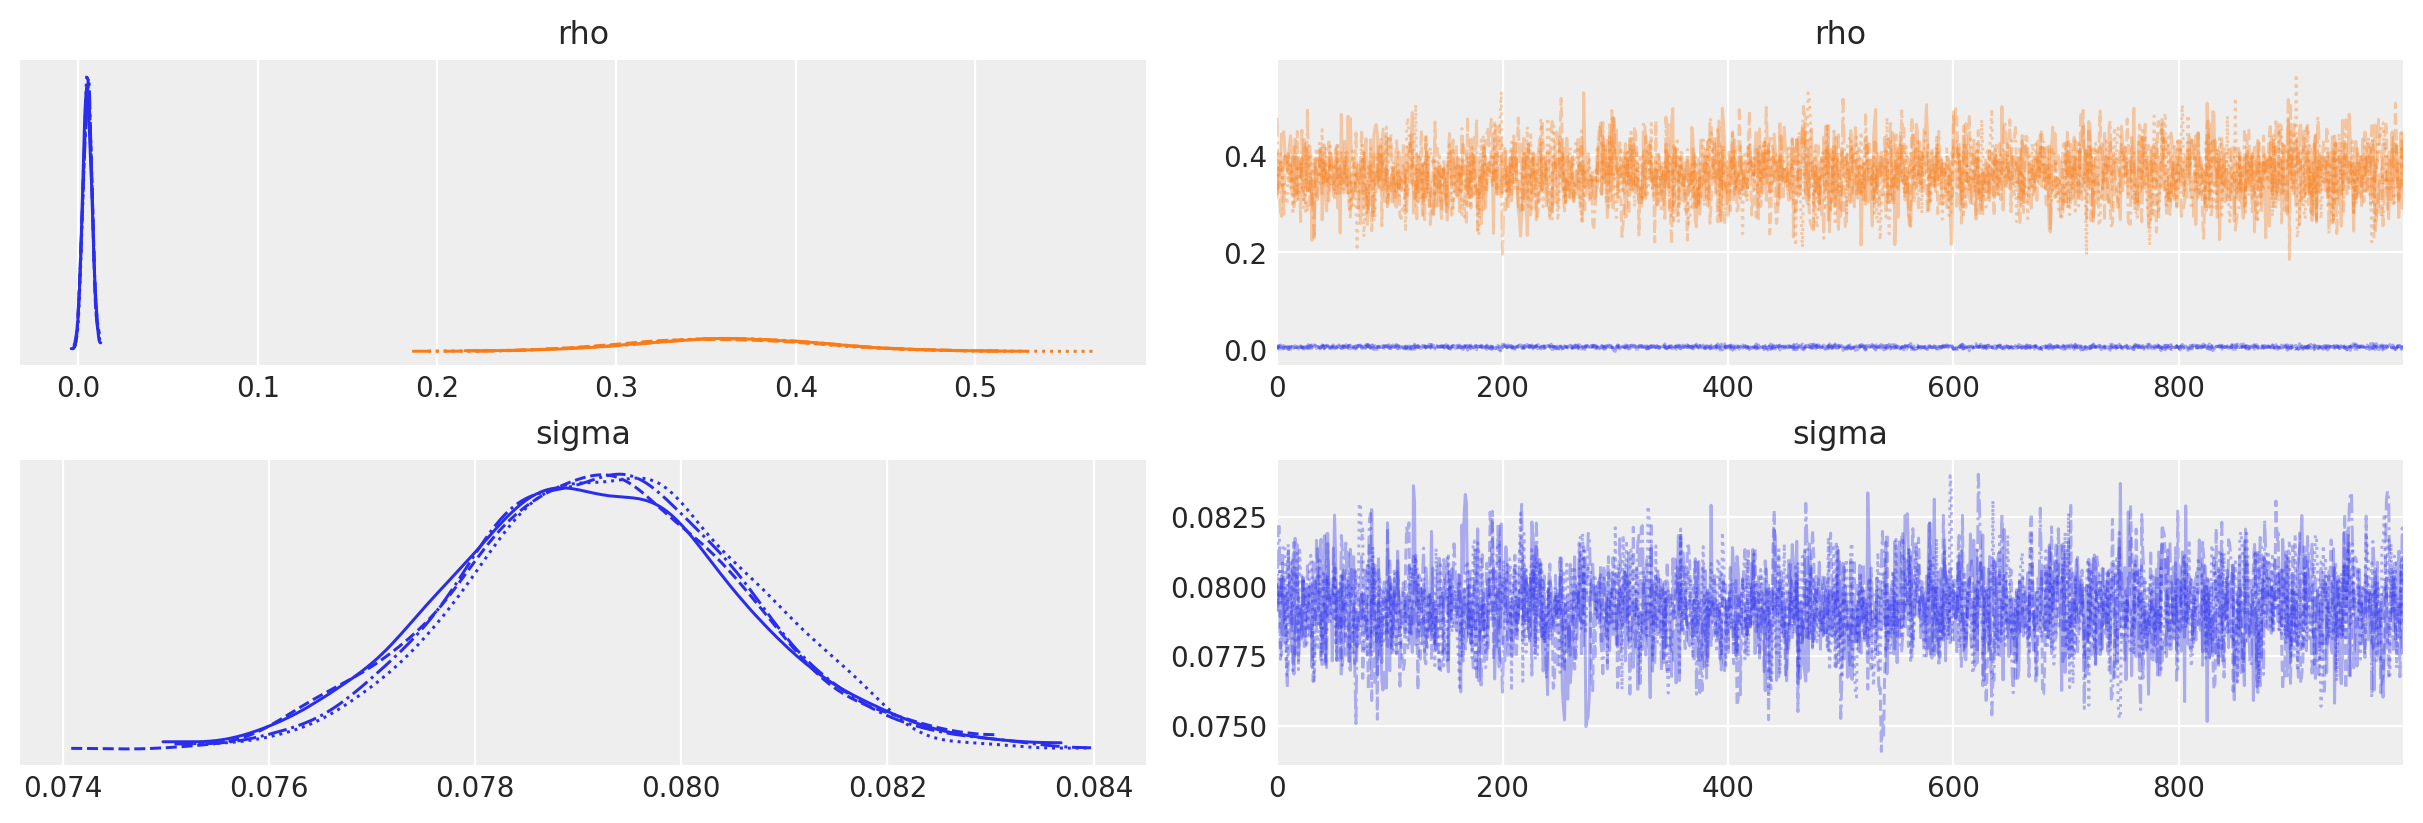

In [ ]:
# AR(1) with constant
y = GDP_25_growth.T

with pm.Model() as ar1wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1wc.extend(pm.compute_log_likelihood(idata_ar1wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1wc
);

In [ ]:
# Stats des coefs
az.summary(idata_ar1wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.005  0.002   0.000    0.010      0.000    0.000    2631.0    2792.0   
rho[1]  0.362  0.052   0.258    0.455      0.001    0.001    2573.0    2812.0   
sigma   0.079  0.001   0.077    0.082      0.000    0.000    2385.0    2412.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [ ]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1wc.log_likelihood.ar1wc.sum(["ar1wc_dim_0"]).mean(["chain","draw"]).values

array(1595.54102569)

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

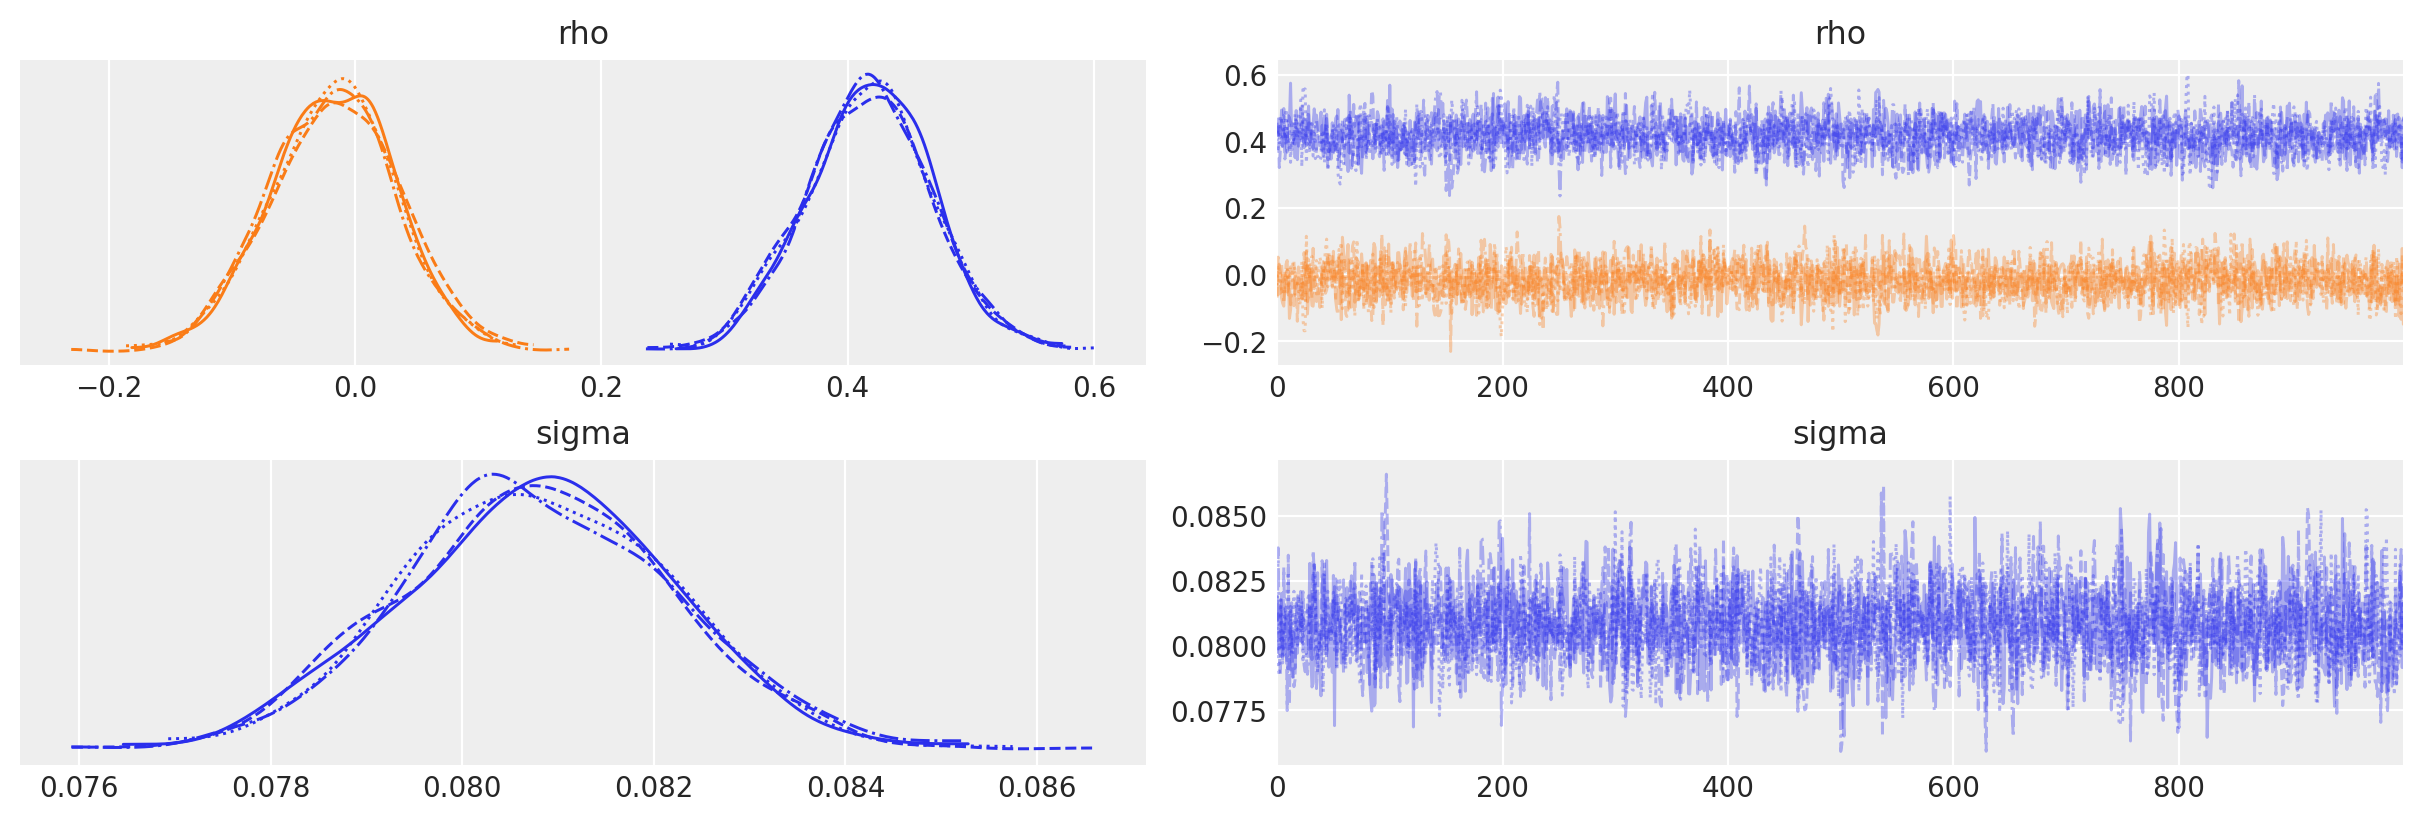

In [ ]:
# AR(2) no constant
y = GDP_25_growth.T

with pm.Model() as ar2nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )
    
    idata_ar2nc.extend(pm.compute_log_likelihood(idata_ar2nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2nc
);

In [ ]:
# Stats des coefs
az.summary(idata_ar2nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.417  0.051   0.318    0.510      0.001    0.001    2226.0    2443.0   
rho[1] -0.017  0.051  -0.109    0.081      0.001    0.001    2351.0    2430.0   
sigma   0.081  0.001   0.078    0.084      0.000    0.000    3018.0    2740.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [ ]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2nc.log_likelihood.ar2nc.sum(["ar2nc_dim_0"]).mean(["chain","draw"]).values

array(1257.22034788)

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

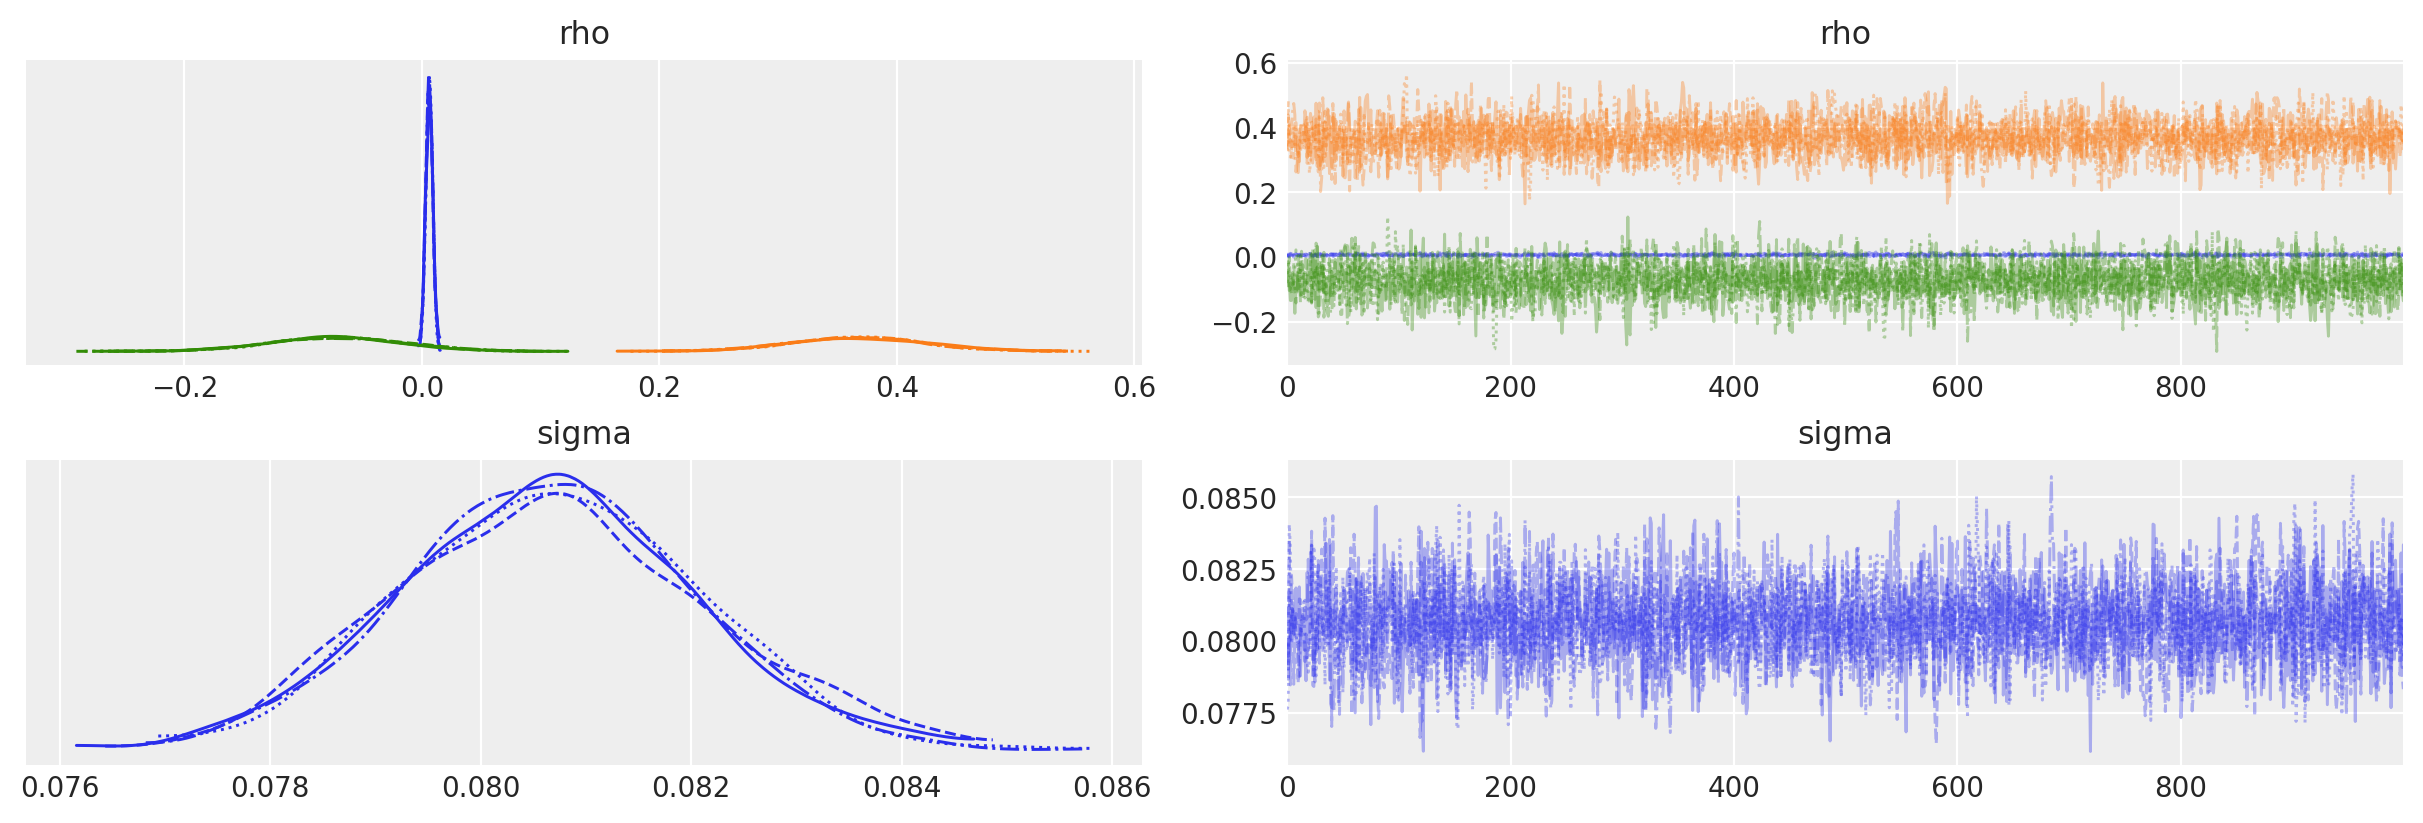

In [ ]:
# AR(2) with constant
y = GDP_25_growth.T

with pm.Model() as ar2wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=3)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar2wc.extend(pm.compute_log_likelihood(idata_ar2wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2wc
);

In [ ]:
# Stats des coefs
az.summary(idata_ar2wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.006  0.003   0.001    0.012      0.000    0.000    3132.0    2809.0   
rho[1]  0.368  0.056   0.261    0.476      0.001    0.001    3167.0    2570.0   
rho[2] -0.072  0.056  -0.178    0.030      0.001    0.001    3601.0    2901.0   
sigma   0.081  0.001   0.078    0.083      0.000    0.000    3516.0    2624.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
rho[2]    1.0  
sigma     1.0

In [ ]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2wc.log_likelihood.ar2wc.sum(["ar2wc_dim_0"]).mean(["chain","draw"]).values

array(1259.06444314)

## Estimation AR(1) AVEC constante

In [ ]:
def initialize_model_ar(y, K, e0=1.0):
    """
    Initialise les paramètres du modèle.
    y: Liste des séries temporelles [N x T]
    K: Nombre de groupes
    e0: Hyperparamètre du Dirichlet
    """
    N,T = y.shape
    eta = dirichlet.rvs([e0] * K, size=1).flatten()  # Dirichlet prior for eta
    S = np.random.choice(K, size=N)  # Random initial classification
    theta = [np.random.randn(2) for _ in range(K)]  # Paramètres pour chaque groupe theta_k=(alpha_k,beta_k)
    sigma = [np.abs(np.random.normal(loc=0, scale=3)) for _ in range(K)] # Prior de sigma = halfnormal

    return eta, S, theta, sigma

In [ ]:
def ar_log_likelihood(yi, thetak, sigmak):
    """
    Calcule la vraisemblance logarithmique d'un modèle AR(p)
    theta, sigma2 : paramètres AR
    yi : série temporelle
    """
    T = len(yi)

    alpha, beta = thetak.iloc[0], thetak.iloc[1]
    sigma2 = sigmak**2

    sigma2_y1 = sigma2 / (1 - beta**2)
    mu_y1 = alpha / (1 - beta)
    
    # Log-vraisemblance pour y1
    ll_y1 = -0.5 * np.log(2 * np.pi * sigma2_y1) - 0.5 * ((yi.iloc[0] - mu_y1)**2 / sigma2_y1)
    
    # Log-vraisemblance pour y2, ..., yT
    residuals = yi.iloc[1:] - (alpha + beta * yi.iloc[:-1])
    ll_rest = -0.5 * (T-1) * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(residuals**2 / sigma2)
    
    return (ll_y1 + ll_rest)

In [ ]:
def ar_log_likelihood_2(yi, thetak, sigmak):
    """
    Calcule la vraisemblance logarithmique d'un modèle AR(1) avec constante
    theta, sigma2 : paramètres AR
    yi : série temporelle
    """
    T = len(yi)

    alpha, beta = thetak.iloc[0], thetak.iloc[1]
    sigma2 = sigmak**2
    
    # Log-vraisemblance pour y2, ..., yT
    residuals = yi.iloc[1:] - (alpha + beta * yi.iloc[:-1])
    ll = -0.5 * (T-1) * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(residuals**2 / sigma2)
    
    return ll

In [ ]:
def sample_S_ar(y, theta, sigma, eta, K):
    """
    Échantillonne les indicateurs de groupe S.
    y : séries temporelles
    theta : paramètres AR pour chaque groupe
    eta : probabilités de groupe
    """
    N,T = y.shape

    log_probs = np.zeros((N, K))
    
    for k in range(K):
        for i in range(N):
            log_probs[i, k] = np.log(eta[k]) + ar_log_likelihood_2(y.iloc[i,:], theta[k], sigma[k])
    
    # Normalisation pour obtenir des probabilités
    probs = np.exp(log_probs - log_probs.max(axis=1, keepdims=True))
    probs /= probs.sum(axis=1, keepdims=True)

    # Échantillonnage des groupes
    S = np.array([np.random.choice(K, p=probs[i]) for i in range(N)])
    return S

In [ ]:
def estimate_ar_params(y):
    """
    Estime les paramètres AR(1) avec constante pour un ensemble de séries.
    """
    # ATTENTION : il faut s'assurer que les pays sont bien en ligne (NxT) 
    # Et qu'il n'y a pas d'autres variables dans le df

    with pm.Model() as ar1wc:
        rho = pm.Normal("rho", 0.0, 1.0, shape=2)
        sigma = pm.HalfNormal("sigma", sigma=3)
        likelihood = pm.AR(
            "ar1wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
        ) # NB : sigma correspond à la standard deviation et pas la variance (=sigma**2)

        idata_ar1wc = pm.sample(
            500,
            tune=500,
            chains=2,
            target_accept=0.9,
            random_seed=RANDOM_SEED,
            progressbar=False,
        )
       
    # Valeur moyenne des coefficients
    theta = az.summary(idata_ar1wc).iloc[0:2,0]
    sigma = az.summary(idata_ar1wc).iloc[2,0]
    
    return theta,sigma

def update_theta_ar(y, S, K):
    """
    Met à jour les paramètres AR pour chaque groupe.
    """
    theta = []
    sigma = []
    for k in range(K):
        group_data = y[S == k]  # Séries assignées au groupe k
        # ATTENTION : il faut vérifier à quoi ressemble "group_data" => pays bien en ligne ? Pas de colonne parasite ? (ex S)
        theta_k,sigma_k = estimate_ar_params(group_data)
        theta.append(theta_k)
        sigma.append(sigma_k)

    return theta,sigma

In [ ]:
def update_eta_ignorance_structure(S, K, e0=1.0):
    """
    Met à jour les probabilités a priori des paramètres eta (structure d'ignorance) influencées  par la distribution actuelle des affectations S.
    """
    counts = np.bincount(S, minlength=K) + e0  # Comptes augmentés par le prior (nombre d'observations assignées à chaque groupe k + e0)
    return dirichlet.rvs(counts, size=1).flatten()

In [ ]:
def mcmc_ar(y, K, num_iterations, e0=1.0):
    """
    Exécute une chaîne MCMC pour estimer les paramètres du modèle AR(1) avec constante avec structure d'ignorance pour eta.
    y : séries temporelles (array [N x T])
    K : nombre de groupes
    num_iterations : nombre d'itérations de MCMC
    e0 : hyperparamètre de la distribution Dirichlet pour eta
    """
    
    # Initialisation des paramètres
    eta, S, theta, sigma = initialize_model_ar(y, K, e0)

    for iter in range(num_iterations):
        # Étape (a) : Échantillonnage des groupes S
        S = sample_S_ar(y, theta, sigma, eta)

        # Étape (b.1) : Mise à jour des paramètres AR pour chaque groupe
        theta,sigma = update_theta_ar(y, S, K)

        # Étape (b.2) : Mise à jour des probabilités de groupe eta
        eta = update_eta_ignorance_structure(S, K, e0)

        # Diagnostics ou suivi des progrès
        if iter % 100 == 0:
            print(f"Iteration {iter}: eta = {eta}")

    return S, theta, sigma, eta


## Estimation AR(1) SANS constante

In [ ]:
def initialize_model_ar(y, K, e0=1.0):
    """
    Initialise les paramètres du modèle.
    y: Liste des séries temporelles [N x T]
    K: Nombre de groupes
    e0: Hyperparamètre du Dirichlet
    """
    N,T = y.shape
    eta = dirichlet.rvs([e0] * K, size=1).flatten()  # Dirichlet prior for eta
    S = np.random.choice(K, size=N)  # Random initial classification
    theta = [np.random.randn(1) for _ in range(K)]  # Paramètre pour chaque groupe theta_k
    sigma = [np.abs(np.random.normal(loc=0, scale=3)) for _ in range(K)] # Prior de sigma = halfnormal

    return eta, S, theta, sigma

In [ ]:
def ar_log_likelihood_2(yi, thetak, sigmak):
    """
    Calcule la vraisemblance logarithmique d'un modèle AR(1) sans constante
    theta, sigma2 : paramètres AR
    yi : série temporelle
    """
    T = len(yi)

    theta = thetak
    sigma2 = sigmak**2
    
    # Log-vraisemblance pour y2, ..., yT
    residuals = yi.iloc[1:] - (theta * yi.iloc[:-1])
    ll = -0.5 * (T-1) * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(residuals**2 / sigma2)
    
    return ll

In [ ]:
def sample_S_ar(y, theta, sigma, eta, K):
    """
    Échantillonne les indicateurs de groupe S.
    y : séries temporelles
    theta / sigma : paramètres AR pour chaque groupe
    eta : probabilités de groupe
    """
    N,T = y.shape

    log_probs = np.zeros((N, K))
    
    for k in range(K):
        for i in range(N):
            log_probs[i, k] = np.log(eta[k]) + ar_log_likelihood_2(y.iloc[i,:], theta[k], sigma[k])
    
    # Normalisation pour obtenir des probabilités
    probs = np.exp(log_probs - log_probs.max(axis=1, keepdims=True))
    probs /= probs.sum(axis=1, keepdims=True)

    # Échantillonnage des groupes
    S = np.array([np.random.choice(K, p=probs[i]) for i in range(N)])
    return S

In [ ]:
def estimate_ar_params(y):
    """
    Estime les paramètres AR(1) sans constante pour un ensemble de séries.
    """
    # ATTENTION : il faut s'assurer que les pays sont bien en ligne (NxT) 
    # Et qu'il n'y a pas d'autres variables dans le df

    with pm.Model() as ar1nc:
        rho = pm.Normal("rho", 0.0, 1.0, shape=1)
        sigma = pm.HalfNormal("sigma", sigma=3)
        likelihood = pm.AR(
            "ar1nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
        ) # NB : sigma correspond à la standard deviation et pas la variance (=sigma**2)

        idata_ar1nc = pm.sample(
            500,
            tune=500,
            chains=2,
            target_accept=0.9,
            random_seed=RANDOM_SEED,
            progressbar=False,
        )
       
    # Valeur moyenne des coefficients
    theta = az.summary(idata_ar1nc).iloc[0,0]
    sigma = az.summary(idata_ar1nc).iloc[1,0]
    
    return theta,sigma

def update_theta_ar(y, S, K):
    """
    Met à jour les paramètres AR pour chaque groupe.
    """
    theta = []
    sigma = []
    for k in range(K):
        group_data = y[S == k]  # Séries assignées au groupe k
        # ATTENTION : il faut vérifier à quoi ressemble "group_data" => pays bien en ligne ? Pas de colonne parasite ? (ex S)
        theta_k,sigma_k = estimate_ar_params(group_data)
        theta.append(theta_k)
        sigma.append(sigma_k)

    return theta,sigma

In [ ]:
def update_eta_ignorance_structure(S, K, e0=1.0):
    """
    Met à jour les probabilités a priori des paramètres eta (structure d'ignorance) influencées  par la distribution actuelle des affectations S.
    """
    counts = np.bincount(S, minlength=K) + e0  # Comptes augmentés par le prior (nombre d'observations assignées à chaque groupe k + e0)
    return dirichlet.rvs(counts, size=1).flatten()

In [ ]:
def mcmc_ar(y, K, num_iterations, e0=1.0):
    """
    Exécute une chaîne MCMC pour estimer les paramètres du modèle AR(1) sans constante avec structure d'ignorance pour eta.
    y : séries temporelles (array [N x T])
    K : nombre de groupes
    num_iterations : nombre d'itérations de MCMC
    e0 : hyperparamètre de la distribution Dirichlet pour eta
    """
    
    # Initialisation des paramètres
    eta, S, theta, sigma = initialize_model_ar(y, K, e0)

    for iter in range(num_iterations):
        # Étape (a) : Échantillonnage des groupes S
        S = sample_S_ar(y, theta, sigma, eta)

        # Étape (b.1) : Mise à jour des paramètres AR pour chaque groupe
        theta,sigma = update_theta_ar(y, S, K)

        # Étape (b.2) : Mise à jour des probabilités de groupe eta
        eta = update_eta_ignorance_structure(S, K, e0)

        # Diagnostics ou suivi des progrès
        if iter % 100 == 0:
            print(f"Iteration {iter}: eta = {eta}")

    return S, theta, sigma, eta


## Exécution sur données réelles

### Série diff + norm

In [ ]:
# Exécution sur série différenciée + normalisée
np.random.seed(42)

# Conversion en tableau NumPy
y = GDP_25_diff_norm.T  # Transpose pour avoir (N, T)

K = 3  # Nombre de clusters
num_iter = 5  # Nombre d'itérations pour le MCMC

# Estimation MCMC
S_est, theta_est, sigma_est, eta_est = mcmc_ar(y, K, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/tmp/ipykernel_17886/4

Iteration 0: eta = [0.04717656 0.05819533 0.89462811]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_00

Classification estimée :  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Paramètres des groupes :  [rho[0]    0.051
rho[1]   -0.015
Name: mean, dtype: float64, rho[0]    0.051
rho[1]   -0.015
Name: mean, dtype: float64, rho[0]    0.528
rho[1]    0.344
Name: mean, dtype: float64]
Paramètres eta :  [0.00703043 0.00694372 0.98602585]


### Série normalisée (attention : pb de stationnarité)

In [ ]:
# Exécution pour des données réelles normalisées sur l'ensemble
np.random.seed(42)

# Conversion en tableau NumPy
y_global = GDP_global_25.values.T  # Transpose pour avoir (N, T)

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC

# Estimation MCMC
S_est, theta_est, eta_est = mcmc_arma(y_global, K, 2, 0, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)


Iteration 0: eta = [0.13734109 0.56517378 0.29748513]
Iteration 100: eta = [0.2842857  0.13624712 0.57946718]
Iteration 200: eta = [0.29039462 0.63451304 0.07509233]
Iteration 300: eta = [0.30630294 0.31722039 0.37647666]
Iteration 400: eta = [0.57922404 0.02641062 0.39436534]
Classification estimée :  [1 1 0 0 1 1 0 0 0 2 0 2 0 2 1 0 0 2 2 2 1 0 0 0 0 1 1 2 0 0 0 2 2 0 1 1 1
 0 1 0 2 0 1 1 2 1 1 2 0 1 0 2 0 1 0 0 1 1 1 0 1 0 0 2 2 0 1 1 2]
Paramètres des groupes :  [array([-0.47449519,  1.40787666]), array([-0.42231031,  0.51687491]), array([-1.07354007, -1.26681498])]
Paramètres eta :  [0.37201194 0.27647577 0.35151229]


In [ ]:
# Exécution pour des données réelles normalisées sur l'ensemble
np.random.seed(42)

# Conversion en tableau NumPy
y = GDP_30.values.T  # Transpose pour avoir (N, T)

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC

# Estimation MCMC
S_est, theta_est, eta_est = mcmc_arma(y, K, 2, 0, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)

NameError: name 'mcmc_arma' is not defined

## Avec modèle logit pour la probabilité d'appartenance

À modifier possiblement : pour calculer chaque coefficient $\gamma_j$, on initialise avec une normale (ici choix de $\mathcal(N)(0,1)$) mais à creuser : comment choisir les paramètres de la loi normale?
J'ai ajouté un intercept à z car dans les coefficients du modèle logit, il est marqué qu'il faut prendre K-1 car la K_ie coordonnée est la ligne de "référence" et d+1 car on veut un intercept (d'où l'indice +1). 
On calcule l'intégrale selon la loi normale pour la likelihood étant donné qu'on a pris une logit de prior normale. 
Pour update les paramètres $\gamma$ de la logit, il est précisé dans l'article qu'on le fait via un algorithme de Metropolis Hastings car on n'a pas de forme explicite. La fonction update_gamma suit donc cette logique. 
Enfin, on utilise un MCMC pour l'échantillonnage et l'update des paramètres. 

In [ ]:
import numpy as np
from scipy.stats import norm

def initialize_model_with_logit(y, z, K, d, mu_gamma=0, sigma_gamma=1):
    N, T = y.shape
    S = np.random.choice(K, size=N)  # Initial random group assignments
    theta = [np.random.randn(T) for _ in range(K)]  # Group-specific parameters
    gamma = np.random.normal(mu_gamma, sigma_gamma, size=(K - 1, d + 1))  # Logit coefficients
    return S, theta, gamma

def sample_S_with_logit(y, z, theta, gamma):
    N = len(y)
    K = len(theta)
    S = np.zeros(N, dtype=int)
    for i in range(N):
        probs = []
        for k in range(K):
            z_with_intercept = np.append(z[i], 1)  # Add intercept term
            logit_prob = np.exp(z_with_intercept @ gamma[k - 1]) if k > 0 else 1
            likelihood = norm.pdf(y[i], loc=theta[k]).prod()
            probs.append(likelihood * logit_prob)
        probs = np.array(probs) / np.sum(probs)
        S[i] = np.random.choice(K, p=probs)
    return S

def update_theta_arma(y, S, K):
    T = y.shape[1]
    theta = []
    for k in range(K):
        group_data = y[S == k]
        if len(group_data) > 0:
            theta_k = np.mean(group_data, axis=0)  # Group mean as an estimate
        else:
            theta_k = np.zeros(T)  # Default if no data assigned to group
        theta.append(theta_k)
    return theta

def update_gamma(S, z, gamma, mu_gamma=0, sigma_gamma=1, step_size=0.1):
    K, d = gamma.shape
    gamma_new = gamma.copy()
    for k in range(K):
        gamma_proposal = gamma[k] + np.random.normal(0, step_size, size=d)
        log_prior_current = -0.5 * np.sum((gamma[k] - mu_gamma) ** 2) / sigma_gamma**2
        log_prior_proposal = -0.5 * np.sum((gamma_proposal - mu_gamma) ** 2) / sigma_gamma**2

        log_likelihood_current = 0
        log_likelihood_proposal = 0
        for i in range(len(S)):
            z_with_intercept = np.append(z[i], 1)  # Add intercept for logit model
            logit_prob_current = np.exp(z_with_intercept @ gamma[k]) / (1 + np.exp(z_with_intercept @ gamma[k]))
            logit_prob_proposal = np.exp(z_with_intercept @ gamma_proposal) / (1 + np.exp(z_with_intercept @ gamma_proposal))
            log_likelihood_current += S[i] * np.log(logit_prob_current)
            log_likelihood_proposal += S[i] * np.log(logit_prob_proposal)

        log_acceptance_ratio = (log_prior_proposal + log_likelihood_proposal) - (
            log_prior_current + log_likelihood_current
        )

        if np.log(np.random.rand()) < log_acceptance_ratio:
            gamma_new[k] = gamma_proposal
    return gamma_new

def mcmc_logit(y, z, K, num_iter):
    N, d = z.shape
    S, theta, gamma = initialize_model_with_logit(y, z, K, d)
    for iteration in range(num_iter):
        S = sample_S_with_logit(y, z, theta, gamma)  # Sample S
        theta = update_theta_arma(y, S, K)  # Update theta
        gamma = update_gamma(S, z, gamma)  # Update gamma
    return S, theta, gamma

# Exécution pour des données réelles normalisées sur l'ensemble
np.random.seed(42)

# Conversion en tableau NumPy
y_global = GDP_global_25.values.T  # Transpose pour avoir (N, T)

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC
d = 2
z = np.random.randn(N, d)  # Exogenous variables

# Estimation MCMC
S_est, theta_est, gamma_est = mcmc_logit(y_global,z, K, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres gamma : ", gamma_est)


Classification estimée :  [1 1 1 1 1 2 1 1 1 1 2 1 2 2 1 2 1 2 1 1 2 1 1 1 1 1 1 2 1 2 1 1 2 2 1 1 1
 1 1 1 2 2 2 2 1 1 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1]
Paramètres des groupes :  [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), array([0.04043609, 0.04101091, 0.04163687, 0.04256847, 0.04401313,
       0.04536101, 0.04688231, 0.04829583, 0.0486729 , 0.0470104 ,
       0.04859307, 0.04968587, 0.05042452, 0.05132295, 0.05234177,
       0.05338465, 0.05421808, 0.0556408 , 0.05689823, 0.05792697,
       0.05546169, 0.05877174, 0.06053192, 0.06175145, 0.04669895]), array([0.01340527, 0.01411242, 0.01496278, 0.01588369, 0.01706466,
       0.01841093, 0.02005405, 0.02205203, 0.02340757, 0.0244415 ,
       0.02651007, 0.02833431, 0.02992864, 0.03167184, 0.03356375,
       0.03563435, 0.03773366, 0.03998443, 0.04233392, 0.04435271,
       0.04418529, 0.0478131 , 0.04952853, 0.05172847, 0.04006782])]
Paramètres g

In [ ]:
GDP_30


Argentina  Australia   Austria   Belgium  Bulgaria   Bolivia  \
Year                                                                   
1995.0   0.255100   0.000000  0.000000  0.000000  0.127484  0.000000   
1996.0   0.317617   0.030497  0.034659  0.020306  0.194087  0.025494   
1997.0   0.415351   0.068106  0.072410  0.079368  0.042826  0.055735   
1998.0   0.465062   0.107140  0.131894  0.111068  0.078101  0.088088   
1999.0   0.419842   0.145945  0.197218  0.169437  0.000000  0.090764   
2000.0   0.409848   0.174250  0.260510  0.232847  0.036144  0.107723   
2001.0   0.352416   0.198741  0.285122  0.252303  0.070884  0.119718   
2002.0   0.218249   0.238931  0.313783  0.282837  0.124303  0.137666   
2003.0   0.316929   0.269280  0.335578  0.301718  0.175799  0.157352   
2004.0   0.372947   0.311924  0.384636  0.367368  0.244086  0.188467   
2005.0   0.484547   0.344624  0.433984  0.411575  0.320722  0.222380   
2006.0   0.594983   0.373763  0.505581  0.461292  0.400178  0.261055   
2007.0   0.728550   0.423285  0.585738  0.534755  0.487576  0.299480   
2008.0   0.794130   0.454177  0.616541  0.544007  0.569071  0.354306   
2009.0   0.694583   0.478178  0.535330  0.504348  0.519614  0.386052   
2010.0   0.854808   0.508314  0.573570  0.559667  0.538726  0.426094   
2011.0   0.959435   0.543852  0.641511  0.600142  0.571523  0.479313   
2012.0   0.940475   0.593539  0.656489  0.604753  0.578617  0.534037   
2013.0   0.984451   0.623742  0.649809  0.611292  0.570222  0.610525   
2014.0   0.937408   0.659561  0.670303  0.649215  0.586299  0.676144   
2015.0   0.987258   0.692958  0.699577  0.681442  0.634138  0.737330   
2016.0   0.948250   0.732303  0.750714  0.707906  0.679706  0.794051   
2017.0   1.000000   0.767993  0.808608  0.741001  0.722013  0.851411   
2018.0   0.950588   0.810851  0.867169  0.783779  0.760896  0.912565   
2019.0   0.913804   0.841390  0.912123  0.840460  0.823463  0.947275   
2020.0   0.735434   0.809955  0.744475  0.726528  0.771915  0.812215   
2021.0   0.904932   0.895391  0.864849  0.866899  0.891810  0.899745   
2022.0   0.999408   0.964133  1.000000  0.968646  0.963765  0.954189   
2023.0   0.969004   1.000000  0.977688  1.000000  1.000000  1.000000   
2024.0   0.000000   0.569277  0.301236  0.382437  0.562741  0.218514   

          Brazil  Botswana    Canada  Switzerland  ...   Romania  \
Year                                               ...             
1995.0  0.000000  0.000000  0.000000     0.000000  ...  0.026666   
1996.0  0.022544  0.014954  0.018966     0.006323  ...  0.056416   
1997.0  0.067687  0.060813  0.067840     0.038831  ...  0.018056   
1998.0  0.072163  0.049843  0.114196     0.082504  ...  0.002778   
1999.0  0.078065  0.105176  0.177795     0.107437  ...  0.000000   
2000.0  0.132761  0.134413  0.244634     0.171422  ...  0.018081   
2001.0  0.152279  0.152927  0.270276     0.197548  ...  0.057362   
2002.0  0.192835  0.210013  0.312062     0.196635  ...  0.102530   
2003.0  0.208985  0.255240  0.337983     0.194832  ...  0.122130   
2004.0  0.284838  0.267212  0.383159     0.236968  ...  0.211478   
2005.0  0.338578  0.312386  0.431512     0.285240  ...  0.255645   
2006.0  0.398854  0.370465  0.472517     0.357219  ...  0.335156   
2007.0  0.492966  0.428026  0.505222     0.427977  ...  0.412544   
2008.0  0.573409  0.463385  0.521428     0.478196  ...  0.519320   
2009.0  0.576426  0.307111  0.473495     0.433794  ...  0.450142   
2010.0  0.709724  0.404042  0.522836     0.494292  ...  0.403865   
2011.0  0.787855  0.474799  0.574467     0.531260  ...  0.455049   
2012.0  0.819725  0.472679  0.604267     0.555152  ...  0.477697   
2013.0  0.883802  0.593285  0.644438     0.592181  ...  0.481076   
2014.0  0.894487  0.661691  0.695222     0.638845  ...  0.531116   
2015.0  0.820695  0.598881  0.707040     0.671695  ...  0.571078   
2016.0  0.750916  0.687320  0.726045     0.716250  ...  0.608421   
2017.0  0.782508  0.741475  0.782140     0.747269  ...  0.718493   
201

In [ ]:
pop_30


Argentina  Australia   Austria   Belgium  Bulgaria   Bolivia  \
Year                                                                   
1961.0   0.000000   0.000000  0.000000  0.000000  0.590379  0.000000   
1962.0   0.013955   0.016011  0.021298  0.014070  0.617926  0.009304   
1963.0   0.028028   0.028870  0.043761  0.040646  0.643647  0.018922   
1964.0   0.042043   0.042285  0.067223  0.074579  0.669761  0.028854   
1965.0   0.055874   0.055947  0.090244  0.107441  0.693363  0.039108   
...           ...        ...       ...       ...       ...       ...   
2020.0   0.986038   0.937580  0.894940  0.904428  0.192287  0.949458   
2021.0   0.990887   0.939816  0.913973  0.922708  0.170088  0.963759   
2022.0   0.994741   0.960154  0.956044  0.958819  0.077609  0.980272   
2023.0   1.000000   1.000000  1.000000  1.000000  0.000000  1.000000   
2024.0   1.000000   1.000000  1.000000  1.000000  0.000000  1.000000   

          Brazil  Botswana    Canada  Switzerland  ...   Romania  \
Year                                               ...             
1961.0  0.000000  0.000000  0.000000     0.000000  ...  0.000000   
1962.0  0.016552  0.006272  0.015715     0.040396  ...  0.026105   
1963.0  0.033389  0.012818  0.031750     0.075266  ...  0.052210   
1964.0  0.050413  0.019630  0.048289     0.102766  ...  0.078310   
1965.0  0.067471  0.023932  0.064462     0.122236  ...  0.102511   
...          ...       ...       ...          ...  ...       ...   
2020.0  0.981837  0.941428  0.905202     0.927637  ...  0.152800   
2021.0  0.988351  0.959636  0.914880     0.946856  ...  0.121984   
2022.0  0.993889  0.979331  0.946914     0.967860  ...  0.106154   
2023.0  1.000000  1.000000  1.000000     1.000000  ...  0.108516   
2024.0  1.000000  1.000000  1.000000     1.000000  ...  0.108516   

        Russian Federation  Singapore  El Salvador    Serbia  Slovenia  \
Year                                                                     
1961.0            0.000000   0.000000     0.000000  0.051692  0.000000   
1962.0            0.049630   0.011340     0.023022  0.091846  0.018084   
1963.0            0.099772   0.021968     0.046128  0.129254  0.043395   
1964.0            0.150501   0.033023     0.070318  0.164480  0.072166   
1965.0            0.201779   0.043770     0.095781  0.198816  0.104552   
...                    ...        ...          ...       ...       ...   
2020.0            0.879385   0.944999     0.978209  0.216468  0.965721   
2021.0            0.861131   0.889904     0.984346  0.165634  0.976475   
2022.0            0.842457   0.933426     0.991480  0.032372  0.984069   
2023.0            0.827411   1.000000     1.000000  0.000000  1.000000   
2024.0            0.827411   1.000000     1.000000  0.000000  1.000000   

          Sweden  Thailand  United States  South Africa  
Year                                                     
1961.0  0.000000  0.000000       0.000000      0.000000  
1962.0  0.013787  0.018843       0.018826      0.011025  
1963.0  0.027955  0.038380       0.036707      0.022601  
1964.0  0.046859  0.058564       0.054211      0.034626  
1965.0  0.070892  0.079369       0.070174      0.047109  
...          ...       ...            ...           ...  
2020.0  0.939273  0.997871       0.977596      0.942770  
2021.0  0.959948  0.999819       0.981049      0.963075  
2022.0  0.983528  1.000000       0.989132      0.981989  
2023.0  1.000000  0.999254       1.000000      1.000000  
2024.0  1.000000  0.999254       1.000000      1.000000  

[64 rows x 52 columns]

In [ ]:
# Exécution pour des données réelles normalisées sur l'ensemble
np.random.seed(42)

# Conversion en tableau NumPy
y_global = GDP_30.values.T  # Transpose pour avoir (N, T)

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC
d = 2
z = np.random.randn(N, d)  # Exogenous variables

# Estimation MCMC
S_est, theta_est, gamma_est = mcmc_logit(y_global,z, K, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres gamma : ", gamma_est)

Classification estimée :  [1 1 2 1 2 2 1 2 2 2 2 2 1 2 1 1 2 2 2 1 2 2 2 1 1 2 1 1 1 1 2 2 1 1 2 1 1
 2 1 2 2 1 2 2 1 1 2 2 1 2 2 1 1 1 2]
Paramètres des groupes :  [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.03828192, 0.07067898, 0.11515017, 0.14091743, 0.17076468,
       0.2178586 , 0.23709931, 0.25624925, 0.28729609, 0.33652281,
       0.38592785, 0.44505631, 0.50760076, 0.52581065, 0.47253014,
       0.52521224, 0.56077227, 0.57394264, 0.60093533, 0.63326769,
       0.67416911, 0.71048434, 0.76576541, 0.80745666, 0.84115926,
       0.76112847, 0.88858582, 0.96190914, 0.99531731, 0.43880529]), array([0.00888367, 0.04314481, 0.07693001, 0.10566241, 0.13349746,
       0.18564737, 0.21801875, 0.25320814, 0.28869648, 0.34377019,
       0.3934657 , 0.46349687, 0.5348694 , 0.56518867, 0.49681415,
       0.53783274, 0.57362593, 0.58727143, 0.61184431, 0.64623541,
       0.67978372, 0.72104

## Modèle AR(1) NC + structure Logit

In [ ]:
def initialize_model_ar_logit(y, z, K, d):
    """
    Initialise les paramètres du modèle.
    y: Liste des séries temporelles [N x T]
    z: variable exogène pour le modèle logit
    K: Nombre de groupes
    d: => ???
    """

    N, T = y.shape
    S = np.random.choice(K, size=N)  # Initial random group assignments
    theta = [np.random.randn(1) for _ in range(K)]  # Paramètre pour chaque groupe theta_k
    sigma = [np.abs(np.random.normal(loc=0, scale=3)) for _ in range(K)] # Prior de sigma = halfnormal
    gamma = np.random.normal(0, 1, size=(K - 1, d + 1))  # Logit coefficients
    return S, theta, sigma, gamma


In [ ]:
def ar_log_likelihood(yi, thetak, sigmak):
    """
    Calcule la vraisemblance logarithmique d'un modèle AR(1) sans constante
    theta, sigma2 : paramètres AR
    yi : série temporelle
    """
    T = len(yi)

    theta = thetak
    sigma2 = sigmak**2
    
    # Log-vraisemblance pour y2, ..., yT
    residuals = yi.iloc[1:] - (theta * yi.iloc[:-1])
    ll = -0.5 * (T-1) * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(residuals**2 / sigma2)
    
    return ll

In [ ]:
def sample_S_ar_logit(y, z, theta, sigma, gamma, K):
    """
    Échantillonne les indicateurs de groupe S.
    y : séries temporelles
    z: variable exogène du logit
    theta / sigma : paramètres AR pour chaque groupe
    gamma : probabilités de groupe
    K: nb de clusters
    """

    N,T = y.shape

    S = np.zeros(N, dtype=int)
    for i in range(N):
        probs = []
        for k in range(K):
            z_with_intercept = np.append(z[i], 1)  # Add intercept term
            logit_prob = np.exp(z_with_intercept @ gamma[k - 1]) if k > 0 else 1
            likelihood = ar_log_likelihood(y.iloc[i,:], theta[k], sigma[k])
            probs.append(likelihood * logit_prob)
        probs = np.array(probs) / np.sum(probs)
        S[i] = np.random.choice(K, p=probs)
    return S


In [ ]:
def estimate_ar_params(y):
    """
    Estime les paramètres AR(1) sans constante pour un ensemble de séries.
    """
    # ATTENTION : il faut s'assurer que les pays sont bien en ligne (NxT) 
    # Et qu'il n'y a pas d'autres variables dans le df

    with pm.Model() as ar1nc:
        rho = pm.Normal("rho", 0.0, 1.0, shape=1)
        sigma = pm.HalfNormal("sigma", sigma=3)
        likelihood = pm.AR(
            "ar1nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
        ) # NB : sigma correspond à la standard deviation et pas la variance (=sigma**2)

        idata_ar1nc = pm.sample(
            500,
            tune=500,
            chains=2,
            target_accept=0.9,
            random_seed=RANDOM_SEED,
            progressbar=False,
        )
       
    # Valeur moyenne des coefficients
    theta = az.summary(idata_ar1nc).iloc[0,0]
    sigma = az.summary(idata_ar1nc).iloc[1,0]
    
    return theta,sigma

In [ ]:
def update_theta_ar_logit(y, S, K):
    """
    Met à jour les paramètres AR pour chaque groupe.
    """
    theta = []
    sigma = []
    for k in range(K):
        group_data = y[S == k]  # Séries assignées au groupe k
        # ATTENTION : il faut vérifier à quoi ressemble "group_data" => pays bien en ligne ? Pas de colonne parasite ? (ex S)
        theta_k,sigma_k = estimate_ar_params(group_data)
        theta.append(theta_k)
        sigma.append(sigma_k)

    return theta,sigma

In [ ]:
def update_gamma_ar_logit(S, z, gamma, mu_gamma=0, sigma_gamma=1, step_size=0.1):
    K, d = gamma.shape
    gamma_new = gamma.copy()
    for k in range(K):
        gamma_proposal = gamma[k] + np.random.normal(0, step_size, size=d)
        log_prior_current = -0.5 * np.sum((gamma[k] - mu_gamma) ** 2) / sigma_gamma**2
        log_prior_proposal = -0.5 * np.sum((gamma_proposal - mu_gamma) ** 2) / sigma_gamma**2

        log_likelihood_current = 0
        log_likelihood_proposal = 0
        for i in range(len(S)):
            z_with_intercept = np.append(z[i], 1)  # Add intercept for logit model
            logit_prob_current = np.exp(z_with_intercept @ gamma[k]) / (1 + np.exp(z_with_intercept @ gamma[k]))
            logit_prob_proposal = np.exp(z_with_intercept @ gamma_proposal) / (1 + np.exp(z_with_intercept @ gamma_proposal))
            log_likelihood_current += S[i] * np.log(logit_prob_current)
            log_likelihood_proposal += S[i] * np.log(logit_prob_proposal)

        log_acceptance_ratio = (log_prior_proposal + log_likelihood_proposal) - (
            log_prior_current + log_likelihood_current
        )

        if np.log(np.random.rand()) < log_acceptance_ratio:
            gamma_new[k] = gamma_proposal
    return gamma_new


## Estimer le nombre optimal de clusters K

en utilisant une prior uniforme pour M_k : Pr(MK)= 1/Kmax
 

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, norm

In [ ]:
def prior_density(theta, sigma, eta):
    log_prior = 0
    for k in range(len(eta)):
        alpha, beta = theta[k]
        log_prior += norm.logpdf(alpha, loc=0, scale=10)
        log_prior += norm.logpdf(beta, loc=0, scale=10)
        log_prior += pm.Halfnorm.logpdf(sigma[k], scale=3)
    log_prior += dirichlet.logpdf(eta, alpha=[1.0] * len(eta))
    return np.exp(log_prior)

In [ ]:
# Fonction de bridge sampling
def bridge_sampling(y, theta_samples, proposal_samples, likelihood_fn, prior_fn):
    """
    Applique le bridge sampling pour estimer la vraisemblance marginale.
    """
    N1 = len(proposal_samples)
    N2 = len(theta_samples)
    
    s1 = N1 / (N1 + N2)
    s2 = N2 / (N1 + N2)
    
    p_y = 1.0  # Initial guess for marginal likelihood
    tolerance = 1e-6
    max_iter = 100
    
    for _ in range(max_iter):
        numerator = 0
        denominator = 0
        
        for theta in proposal_samples:
            numerator += likelihood_fn(y, theta) * prior_fn(theta) / (s1 * likelihood_fn(y, theta) * prior_fn(theta) + s2 * p_y)
        numerator /= N1
        
        for theta in theta_samples:
            denominator += 1 / (s1 * likelihood_fn(y, theta) * prior_fn(theta) + s2 * p_y)
        denominator /= N2
        
        new_p_y = numerator / denominator
        if np.abs(new_p_y - p_y) < tolerance:
            break
        p_y = new_p_y
    
    return p_y

In [ ]:
# Algorithme MCMC avec choix du nombre optimal de clusters
def mcmc_ar_bridge(y, K_max, num_iterations, e0=1.0):
    """
    Exécute une chaîne MCMC pour estimer les paramètres et le nombre optimal de clusters.
    """
    N, T = y.shape
    marginal_likelihoods = []
    results = {}
    
    for K in range(1, K_max + 1):
        eta, S, theta, sigma = initialize_model_ar(y, K, e0)
        all_params = {"eta": [], "S": [], "theta": [], "sigma": []}

        for _ in range(num_iterations):
            S = sample_S_ar(y, theta, sigma, eta, K)
            theta, sigma = update_theta_ar(y, S, K)
            eta = update_eta_ignorance_structure(S, K, e0)

            # Sauvegarde des paramètres à chaque itération
            all_params["eta"].append(eta.copy())
            all_params["S"].append(S.copy())
            all_params["theta"].append(theta.copy())
            all_params["sigma"].append(sigma.copy())
        
        # Calcul de la vraisemblance marginale via bridge sampling
        proposal_samples = [np.random.randn(2) for _ in range(100)]  # Échantillons de la distribution de proposition
        marginal_likelihood = bridge_sampling(
            y,
            theta,
            proposal_samples,
            lambda y, theta: np.exp(ar_log_likelihood(y, S, theta, sigma)),
            lambda theta: prior_density(theta, sigma, eta)
        )
        marginal_likelihoods.append(marginal_likelihood)

        # Sauvegarde des résultats pour ce K
        results[K] = {"marginal_likelihood": marginal_likelihood, "parameters": all_params}

    
    # Choix du K optimal
    best_K = np.argmax(marginal_likelihoods) + 1

    return best_K, results

### test sur des données simulées

In [ ]:
# Simuler des données pour le test
def simulate_data(N, T, K, true_theta, true_sigma):
    """
    Simule des séries temporelles pour N individus avec T observations,
    appartenant à K clusters définis par true_theta et true_sigma.
    """
    y = np.zeros((N, T))
    true_S = np.random.choice(K, size=N)  # Attribution aléatoire des clusters
    for i in range(N):
        cluster = true_S[i]
        alpha, beta = true_theta[cluster]
        sigma = true_sigma[cluster]
        y[i, 0] = np.random.normal(loc=0, scale=sigma)  # Initialisation
        for t in range(1, T):
            y[i, t] = alpha + beta * y[i, t-1] + np.random.normal(loc=0, scale=sigma)
    return y, true_S

# Paramètres pour la simulation
N = 50  # Nombre de séries temporelles
T = 20  # Longueur des séries temporelles
K_true = 3  # Nombre réel de clusters
true_theta = [(0.5, 0.8), (-0.5, 0.6), (1.0, 0.3)]  # (alpha_k, beta_k) pour chaque cluster
true_sigma = [0.5, 0.3, 0.7]  # sigma_k pour chaque cluster

# Générer des données simulées
y, true_S = simulate_data(N, T, K_true, true_theta, true_sigma)

In [ ]:
# Tester l'algorithme MCMC avec bridge sampling
K_max = 5  # Nombre maximum de clusters à tester
num_iterations = 10  # Petit nombre d'itérations pour le test rapide

# Appeler la fonction mcmc_ar_bridge
best_K, marginal_likelihoods, parameters_by_K = mcmc_ar_bridge(y, K_max, num_iterations)

# Résultats
print(f"Nombre de clusters optimal estimé : {best_K}")
print("Vraisemblance marginale pour chaque K :")
for K, likelihood in enumerate(marginal_likelihoods, 1):
    print(f"K={K}, marginal likelihood={likelihood:.4f}")
print("\nParamètres estimés pour K optimal :")
print(parameters_by_K[best_K])

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'